# Vaccine Effectiveness

### Inference of Covid-19 vaccines effectiveness and uncertainty using bayesian methods

Course: 2023-2024

Authors:

Joan Verguizas I Moliner | ID: 2085821

Wageesha Widuranga       | ID: 2078719

In [1]:
system("sudo apt-get update")
system("sudo apt-get install -y jags")

In [2]:
install.packages("StanHeaders")
install.packages("coda")
install.packages("bayesplot")
install.packages("patchwork")
install.packages("dplyr")
install.packages("tidyr")
install.packages("tidybayes")
install.packages("bayestestR")
install.packages("ggmcmc")
install.packages("viridis")
install.packages("rjags")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(ggplot2)
library(StanHeaders)
library(coda)
library(rjags)
library(bayesplot)
library(patchwork)
library(dplyr)
library(tibble)
library(tidyr)
library(ggmcmc)
library (tidybayes)
library(bayestestR)
library(viridis)

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs

This is bayesplot version 1.11.1

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘bayestestR’


The following object is masked from ‘package:tidybayes’:

    hdi


The following object is masked from ‘package:ggmcmc’:

    ci


Loading required package: viridisLite



Several Covid-19 Vaccines have been authorized by the European Medicines Agency (EMA). Using the official data of the clinical trials from the EMA [webpage](https://www.ema.europa.eu/), we can compute the efficacy for each vaccine in different clinical trial contexts.

The Covid-19 vaccines we are going to review are as follows:
- Comirnaty
- Nuvaxovid
- Ronapreve
- Xevudy
- Spikevax

We will perform a study on each of the trials of these vaccines.

Effectiveness
In medicine, effectiveness refers to how well a treatment works in real-world settings, as demonstrated through pragmatic clinical trials. This is distinct from efficacy, which measures how well a treatment performs under ideal conditions, such as in controlled research studies or clinical trials.

To quantify effectiveness, we use the following formula:

$\text{Effectiveness} = \frac{\text{Theta Placebo} - \text{Theta Vaccine}}{\text{Theta Placebo}} \times 100$

This formula calculates the percentage difference in outcomes between the treated and control groups, providing a measure of how effectively the treatment performs in practical, everyday conditions.

## Efficacy of Vaccines for Reducing Symptomatic Covid in People with no Previous Infection

### Comirnaty

Comirnaty is a covid-19 vaccine used in people from the age of 6 months based on mRNA technology. The main trail involved around 36,000 people aged 16 above who had no sign of previous infection. Half received the vaccine and half the dummy injection.

The study showed a 95% reduction in the number of symptomatic COVID-19 cases in the people that received the vaccine (8 cases out of 18,198 got COVID symptoms) compared with people that received the dummy injection (162 cases out of 18,325 got COVID symptoms).

In [4]:
#Table for Comirnaty vaccine trial information
vacc.tot <- 18198
pla.tot <- 18325
vacc.pos <- 8
pla.pos <- 162

vaccine.info <- function(vacc.tot, pla.tot, vacc.pos, pla.pos) {
    patient <- c(rep("Vaccinated", vacc.tot), rep("Placebo", pla.tot))
    tested <- c(rep("Pos", vacc.pos), rep("Neg", vacc.tot - vacc.pos), rep("Pos", pla.pos),
                rep("Neg", pla.tot - pla.pos))
    vacc.table <- tibble(patient = patient, tested=tested)
    return(vacc.table)
}

comirnaty.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.pos, pla.pos=pla.pos)
table(comirnaty.tb[[1]], comirnaty.tb[[2]])


            
               Neg   Pos
  Placebo    18163   162
  Vaccinated 18190     8

In [5]:
model.betaprior <- function(alpha, beta) {

    modelString <- sprintf("
    model {
        for (i in 1:Ntot ) {
            tested[i] ~ dbern (theta[patient[i]])
        }
        for (k in 1: Nclass) {
            theta[k] ~ dbeta (%f, %f) # beta prior
        }
    }", alpha, beta)

    modelFile <- "model.jags"
    writeLines(modelString, con=modelFile)

    return(modelFile)
}

In [6]:
create_samples <- function(table.tb, modelFile) {

    dataList = list(
    tested = ifelse(table.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(table.tb$patient)),
    Ntot = nrow(table.tb),
    Nclass = nlevels(factor(table.tb$patient)))

    model <- jags.model(modelFile, data = dataList, n.chains = 4, quiet = TRUE)
    posterior_samples <- coda.samples(model, variable.names = "theta", n.iter = 10000)

    return(posterior_samples)
}

modelFile <- model.betaprior(alpha = 1, beta = 1)

post.comirnaty <- create_samples(comirnaty.tb, modelFile=modelFile)

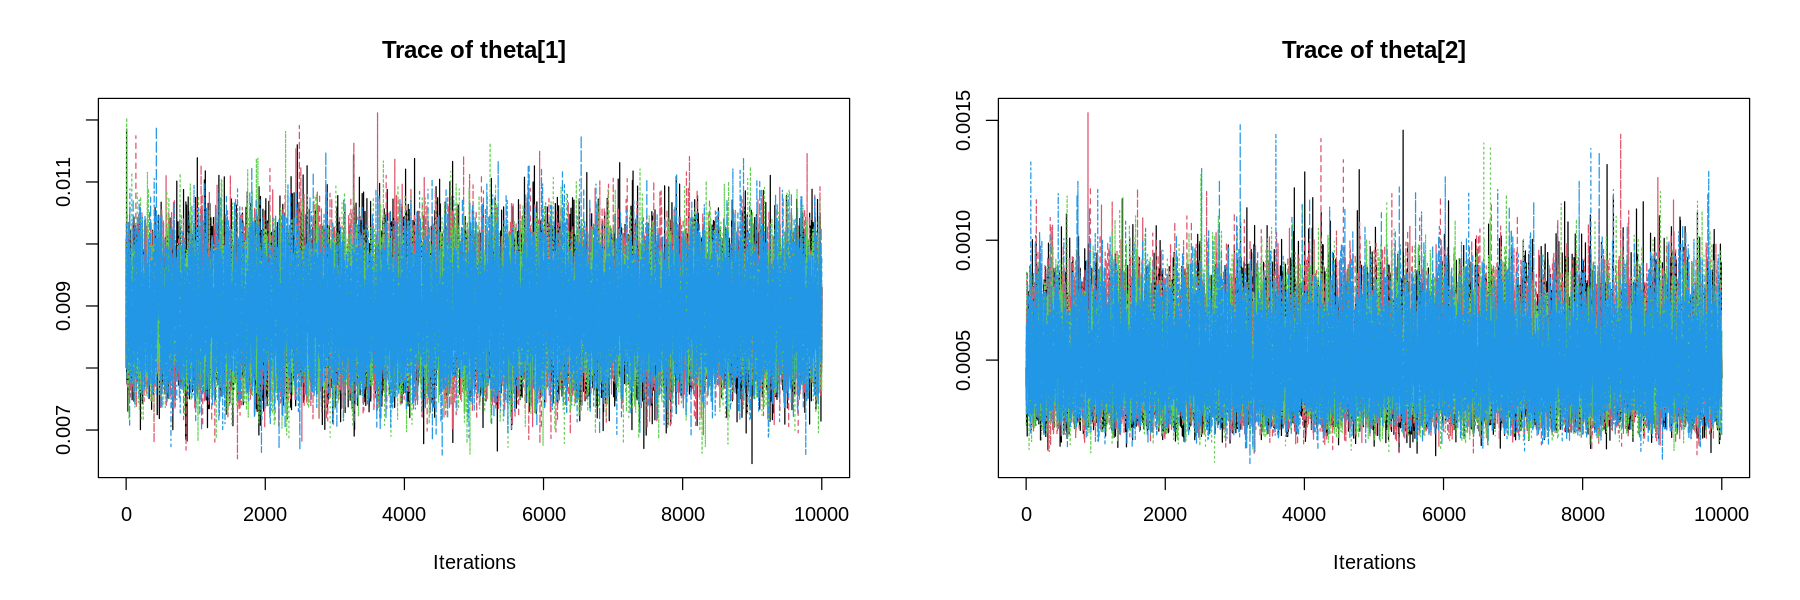

In [7]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.comirnaty)

The traceplots for both parameters show a "fuzzy caterpillar" shape which means that chains are exploring the parameter space effectively.

In [8]:
placebo <- unlist(post.comirnaty[, "theta[1]"])
vaccine <- unlist(post.comirnaty[, "theta[2]"])

lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)

p = seq(from = lower_p, to = upper_p, length.out = 512)

comirnaty.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
comirnaty = density(vaccine)$y / sum(density(vaccine)$y))

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


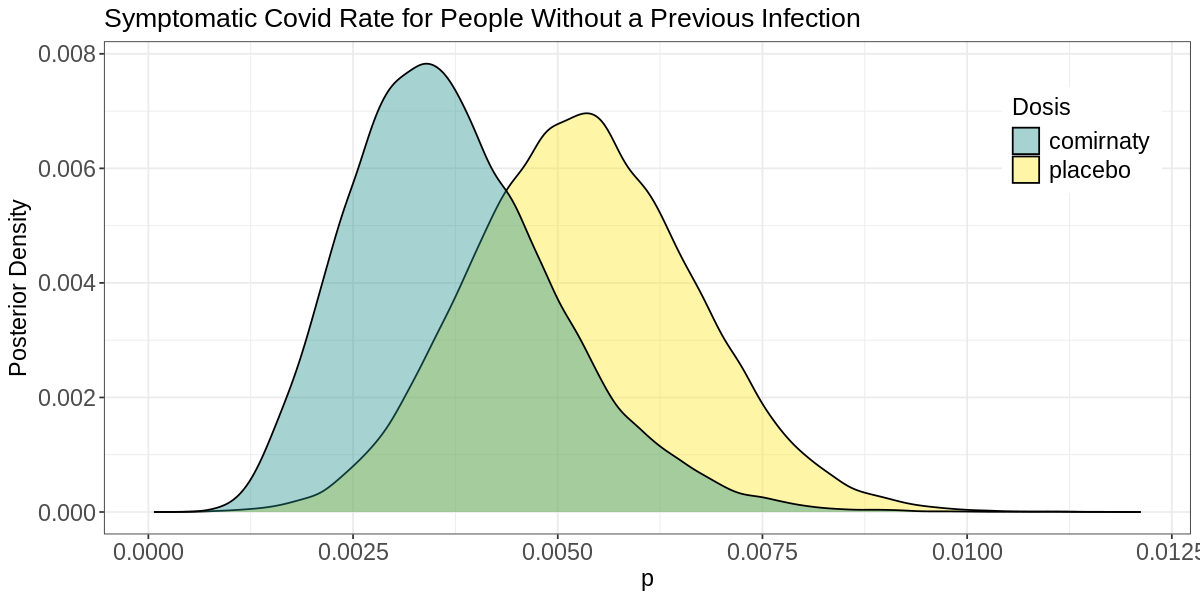

In [9]:
options(repr.plot.width=10, repr.plot.height=5)
posterior_plots <- function(data, title, vaccine) {
  ggplot(data = data, aes(x=p)) +
      geom_area(aes(y = placebo, fill = "placebo"), color = "black", alpha=0.4) +
      geom_area(aes(y = !!rlang::sym(vaccine), fill = vaccine), color = "black", alpha=0.4) +
      labs(x = "p", y = "Posterior Density", title = title, fill = "Dosis") +
      scale_fill_manual(values = setNames(c(viridis(3)[3], viridis(3)[2]),
                                          c("placebo", vaccine))) +
      theme_bw() +
      theme(plot.title = element_text(size=16),
           axis.title = element_text(size=14),
           axis.text = element_text(size=14),
           legend.text = element_text(size=14),
           legend.title = element_text(size=14),
           legend.position = c(0.9, 0.8))
}

posterior_plots(comirnaty.data, title="Symptomatic Covid Rate for People Without a Previous Infection", vaccine="comirnaty")


In [10]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)
efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)
comirnaty.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)
comirnaty.mean <- mean(vaccine.efficacy)
comirnaty.median <- quantile(vaccine.efficacy, 0.5)[[1]]
comirnaty.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
comirnaty.upper <- quantile(vaccine.efficacy, 0.975)[[1]]


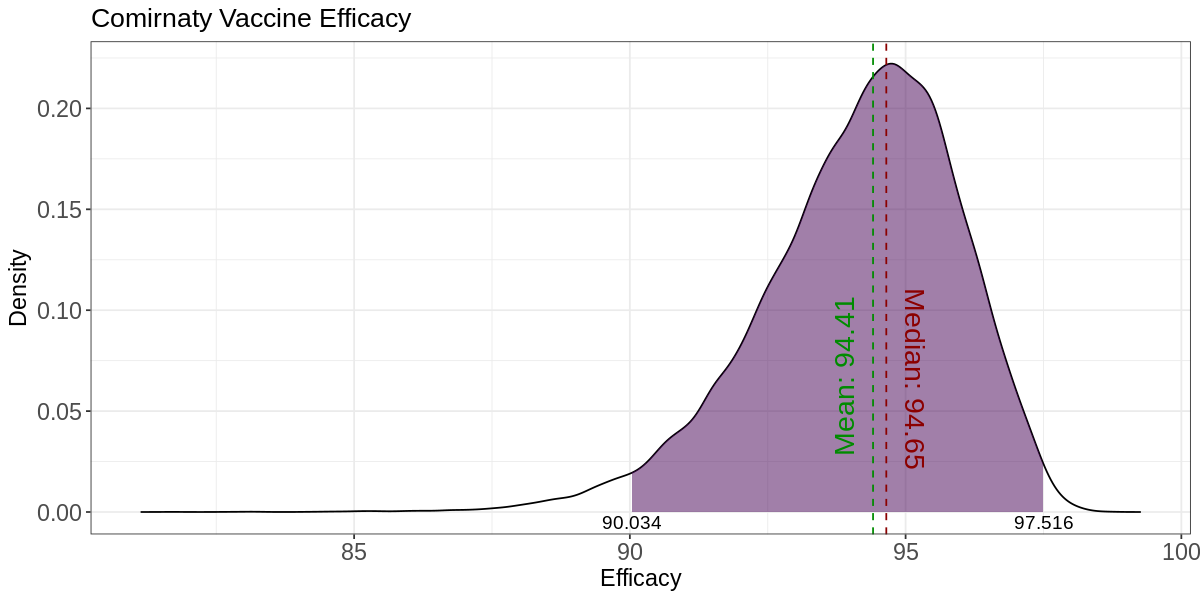

In [11]:
efficacy_plot <- function(data, lower_interval, upper_interval, mean, median, title) {
  ggplot(data = data) +
      geom_line(aes(x=efficacy, y = density), color = "black") +
      geom_ribbon(aes(x = efficacy, ymin = 0, ymax = density), fill = viridis(3)[1], alpha=0.5, data = subset(data, efficacy >= lower_interval & efficacy <= upper_interval)) +
      geom_vline(xintercept = median, linetype = "dashed", color = "red4") +
      geom_vline(xintercept = mean, linetype = "dashed", color = "green4") +
      annotate(geom = "text", x = lower_interval, y = 0, label = paste(round(lower_interval, 3)), vjust = 1.3, hjust = 0.5, size = 4, color = "black") +
      annotate(geom = "text", x = upper_interval, y = 0, label = paste(round(upper_interval, 3)), vjust = 1.3, hjust = 0.5, size = 4, color = "black") +
      annotate(geom = "text", x = median, y = max(data$density)/2, label = paste("Median:", round(median, 3)), vjust = -1, hjust = 0, size = 6, color = "red4", angle=-90) +
      annotate(geom = "text", x = mean, y = max(data$density)/2, label = paste("Mean:", round(mean, 3)), vjust = -1, hjust = 1.05, size = 6, color = "green4", angle=90) +
      labs(x = "Efficacy", y = "Density", title = title) +
      theme_bw() +
      theme(plot.title = element_text(size=16),
           axis.title = element_text(size=14),
           axis.text = element_text(size=14))
}

efficacy_plot(comirnaty.data, comirnaty.lower, comirnaty.upper, comirnaty.mean, comirnaty.median, title="Comirnaty Vaccine Efficacy")

The study claimed a 95% efficiency for the comirnaty vaccine for symptomatic covid19 cases. This value falls within the 95% confidence interval of our simulation.

In [12]:
comirnaty.trial <- 95

comirnaty.results <- data.frame( mean = comirnaty.mean, median=comirnaty.median, trial = comirnaty.trial, lower_interval = comirnaty.lower, upper_interval = comirnaty.upper); comirnaty.results

mean     median   trial lower_interval upper_interval
1 94.40992 94.64997 95    90.03385       97.51588

### Nuvaxovid

Results from clinical trials found that Nuvaxovid was effective at preventing COVID-19 in people from 12 years of age when given as primary vaccination. In these studies, over 25,000 people were given two doses of Nuvaxovid or placebo (a dummy injection).

In the study, around two thirds of participants received the vaccine and the others were given placebo. The study found a 90.4% reduction in the number of symptomatic COVID-19 cases from 7 days after the second dose in adults who received Nuvaxovid (14 cases out of 17,312 people) compared with adults given placebo (63 out of 8,140 people). This means that the vaccine had a 90.4% efficacy in this study.

In [13]:
vacc.tot <- 17312
pla.tot <- 8140
vacc.pos <- 14
pla.pos <- 63
nuvaxovid.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.pos, pla.pos=pla.pos)
table(nuvaxovid.tb[[1]], nuvaxovid.tb[[2]])

            
               Neg   Pos
  Placebo     8077    63
  Vaccinated 17298    14

In [14]:
modelFile <- model.betaprior(alpha = 1, beta = 1)
post.nuvaxovid <- create_samples(nuvaxovid.tb, modelFile=modelFile)

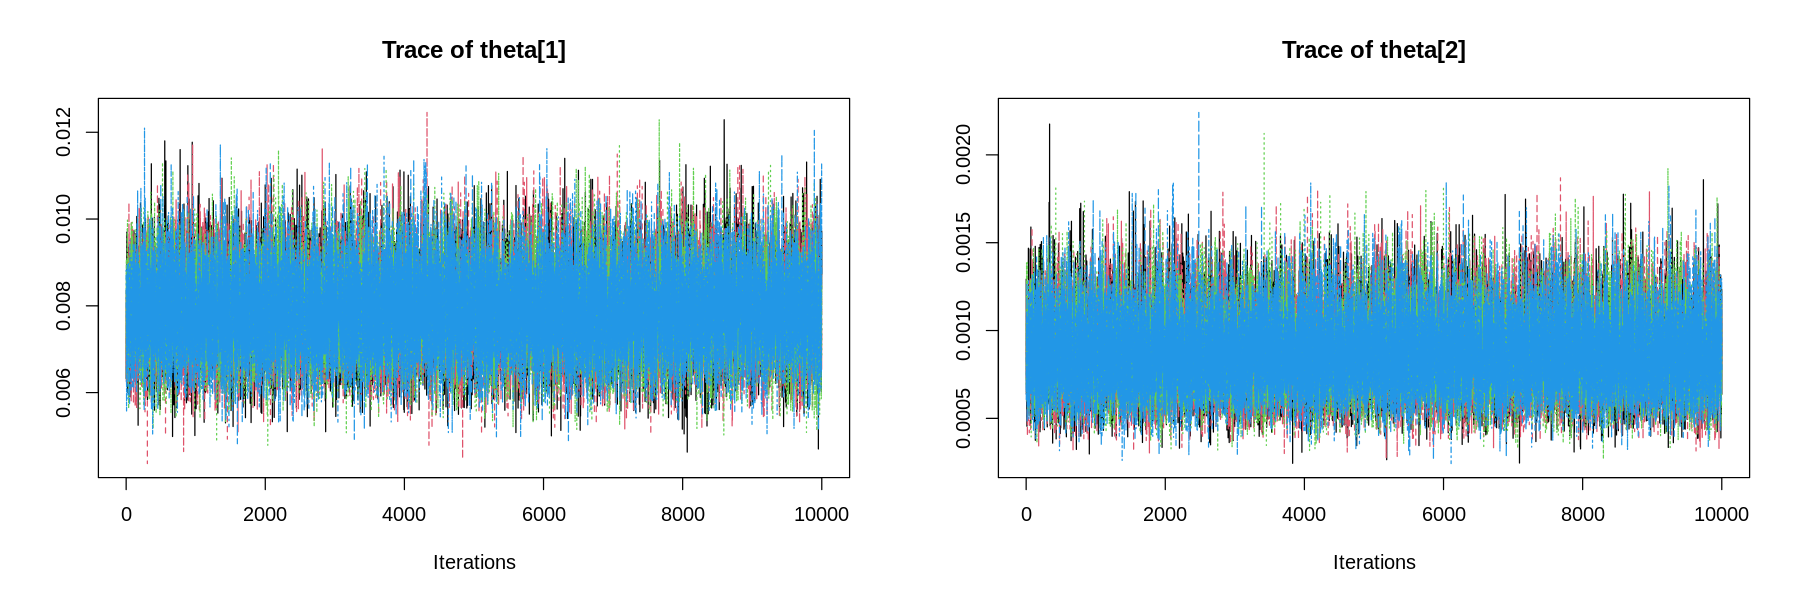

In [15]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.nuvaxovid)

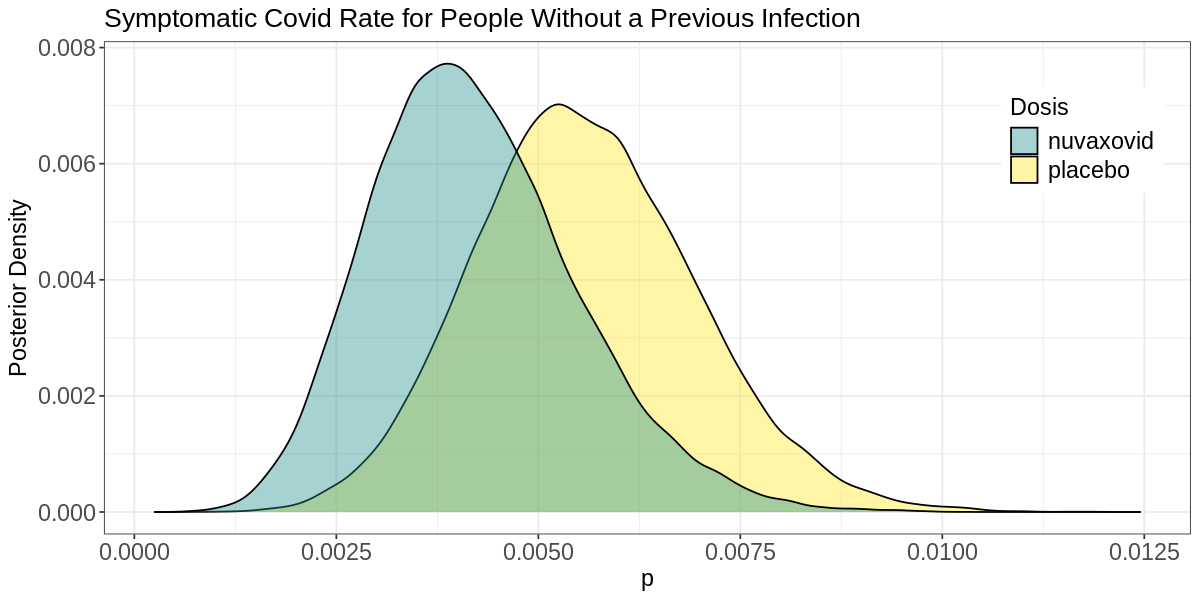

In [16]:
placebo <- unlist(post.nuvaxovid[, "theta[1]"])
vaccine <- unlist(post.nuvaxovid[, "theta[2]"])
lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)

p = seq(from = lower_p, to = upper_p, length.out = 512)

nuvaxovid.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
nuvaxovid = density(vaccine)$y / sum(density(vaccine)$y))

options(repr.plot.width=10, repr.plot.height=5)
posterior_plots(nuvaxovid.data, title="Symptomatic Covid Rate for People Without a Previous Infection", vaccine="nuvaxovid")

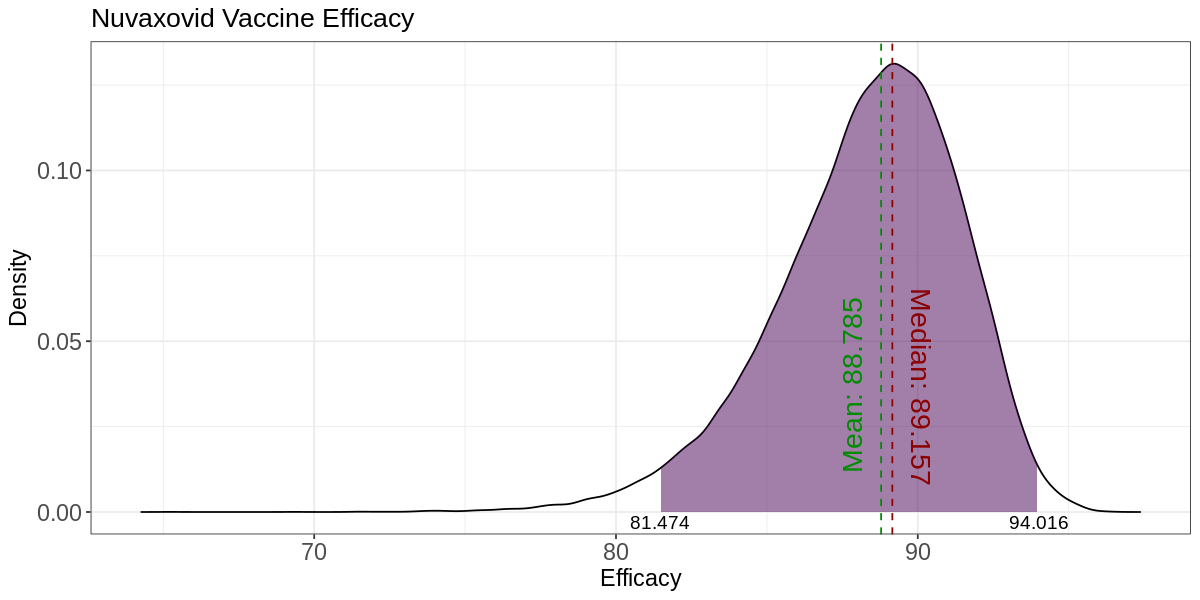

In [17]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)
efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)
nuvaxovid.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)

nuvaxovid.mean <- mean(vaccine.efficacy)
nuvaxovid.median <- quantile(vaccine.efficacy, 0.5)[[1]]
nuvaxovid.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
nuvaxovid.upper <- quantile(vaccine.efficacy, 0.975)[[1]]

efficacy_plot(nuvaxovid.data, nuvaxovid.lower, nuvaxovid.upper,
nuvaxovid.mean, nuvaxovid.median, title = "Nuvaxovid Vaccine Efficacy")

The nuvaxovid clinical trail informed of a 90.4% reduction in the number of symptomatic COVID-19 cases which value falls within the 95% confidence interval of our simulation.

In [18]:
nuvaxovid.trial <- 90.4

nuvaxovid.results <- data.frame(mean = nuvaxovid.mean, median=nuvaxovid.median, trial = nuvaxovid.trial, lower_interval = nuvaxovid.lower, upper_interval = nuvaxovid.upper); nuvaxovid.results

mean     median   trial lower_interval upper_interval
1 88.78543 89.15692 90.4  81.47401       94.01636

### Spikevax

Spikevax is a vaccine for preventing coronavirus disease 2019 (COVID-19) in people from the age of 6 months.

Efficacy was calculated in around 28,000 people from 18 to 94 years of age who had no sign of previous infection. The trial showed a 94.1% reduction in the number of symptomatic COVID-19 cases in the people who received the vaccine (11 out of 14,134 vaccinated people got COVID-19 with symptoms) compared with people who received dummy injections (185 out of 14,073 people who received dummy injections got COVID-19 with symptoms). This means that the vaccine demonstrated a 94.1% efficacy in the trial.

In [19]:
vacc.tot <- 14134
pla.tot <- 14073
vacc.pos <- 11
pla.pos <- 185
spikevax.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.pos, pla.pos=pla.pos)
table(spikevax.tb[[1]], spikevax.tb[[2]])

            
               Neg   Pos
  Placebo    13888   185
  Vaccinated 14123    11

In [20]:
modelFile <- model.betaprior(alpha = 1, beta = 1)
post.spikevax <- create_samples(spikevax.tb, modelFile=modelFile)

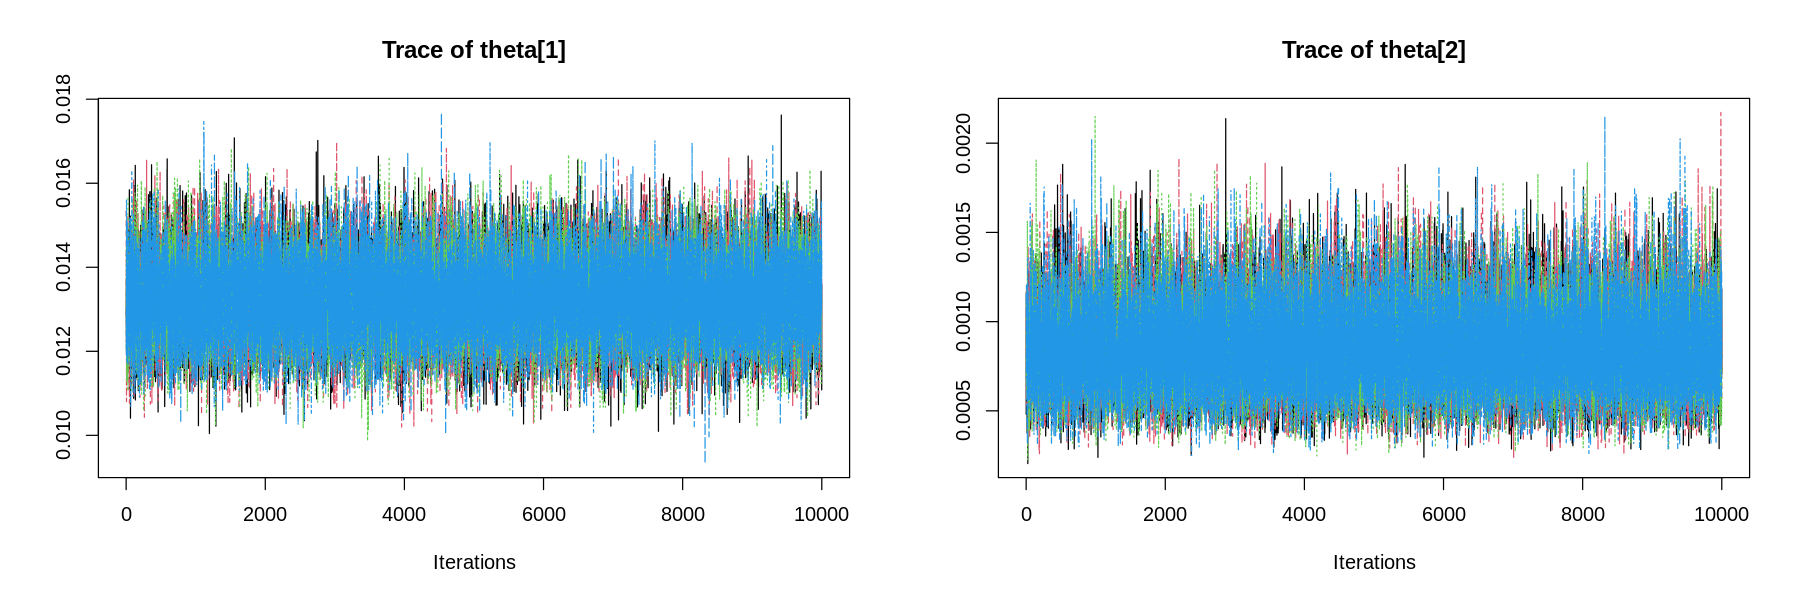

In [21]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.spikevax)

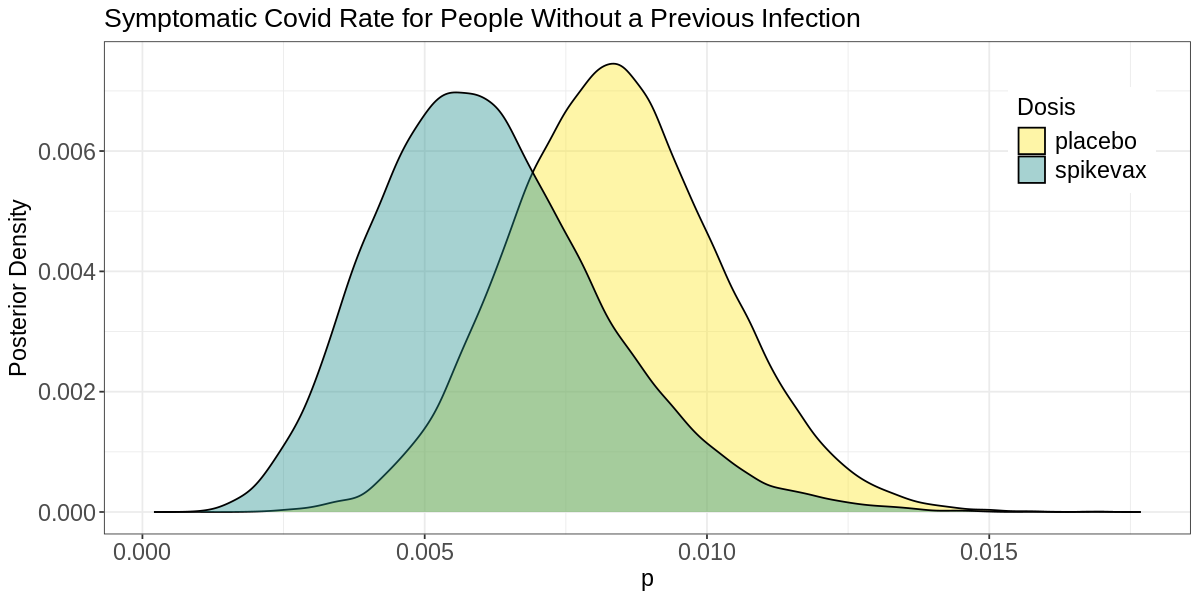

In [22]:
placebo <- unlist(post.spikevax[, "theta[1]"])
vaccine <- unlist(post.spikevax[, "theta[2]"])

lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)

p = seq(from = lower_p, to = upper_p, length.out = 512)
spikevax.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
spikevax = density(vaccine)$y / sum(density(vaccine)$y))

options(repr.plot.width=10, repr.plot.height=5)
posterior_plots(spikevax.data, title="Symptomatic Covid Rate for People Without a Previous Infection", vaccine="spikevax")

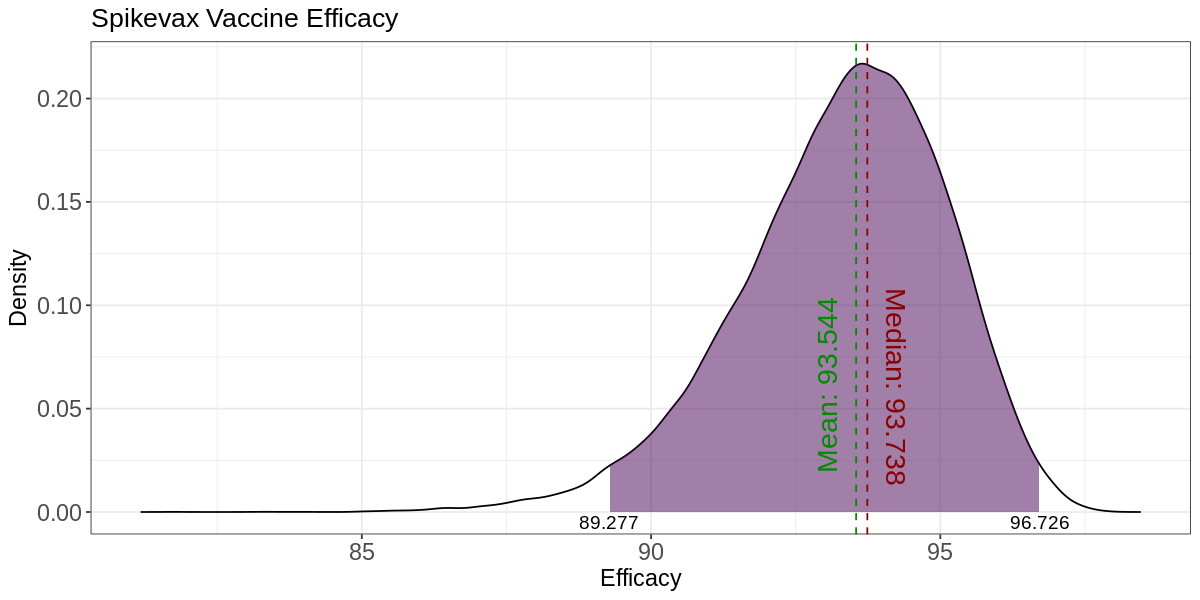

In [23]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)

efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)

spikevax.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)

spikevax.mean <- mean(vaccine.efficacy)
spikevax.median <- quantile(vaccine.efficacy, 0.5)[[1]]
spikevax.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
spikevax.upper <- quantile(vaccine.efficacy, 0.975)[[1]]

efficacy_plot(spikevax.data, spikevax.lower, spikevax.upper, spikevax.mean, spikevax.median, title="Spikevax Vaccine Efficacy")

We can see that in the case of treatment the spikevax vaccine gets a mean 93.7% increase in efficiency with respect to the placebo results. The 95% confidence interval ranges from 89.2% to 96.7% in which the claimed efficiency of 94.1% falls within.

In [24]:
spikevax.trial <- 94.1

spikevax.results <- data.frame(mean = spikevax.mean, median=spikevax.median,
trial = spikevax.trial, lower_interval = spikevax.lower, upper_interval = spikevax.upper); spikevax.results

mean    median   trial lower_interval upper_interval
1 93.5445 93.73783 94.1  89.27707       96.72587

### Comparision Between Comirnaty vs Nuvaxovid vs Spikevax

The aforementioned 3 vaccines efficiency have been tested using healthy individuals and overviewing the difference in which symptomatic covid arises between vaccinated and unvaccinated patients. The results are:

In [25]:
results <- rbind(comirnaty.results, nuvaxovid.results, spikevax.results)

row.names(results) <- c("Comirnaty", "Nuvaxovid", "Spikevax")

results <- results %>% arrange(desc(median)); results

mean     median   trial lower_interval upper_interval
Comirnaty 94.40992 94.64997 95.0  90.03385       97.51588      
Spikevax  93.54450 93.73783 94.1  89.27707       96.72587      
Nuvaxovid 88.78543 89.15692 90.4  81.47401       94.01636

In [26]:
data <- data.frame(efficacy_comirnaty = comirnaty.data$efficacy, density_comirnaty = comirnaty.data$density,
                  efficacy_nuvaxovid = nuvaxovid.data$efficacy, density_nuvaxovid = nuvaxovid.data$density,
                  efficacy_spikevax = spikevax.data$efficacy, density_spikevax = spikevax.data$density)

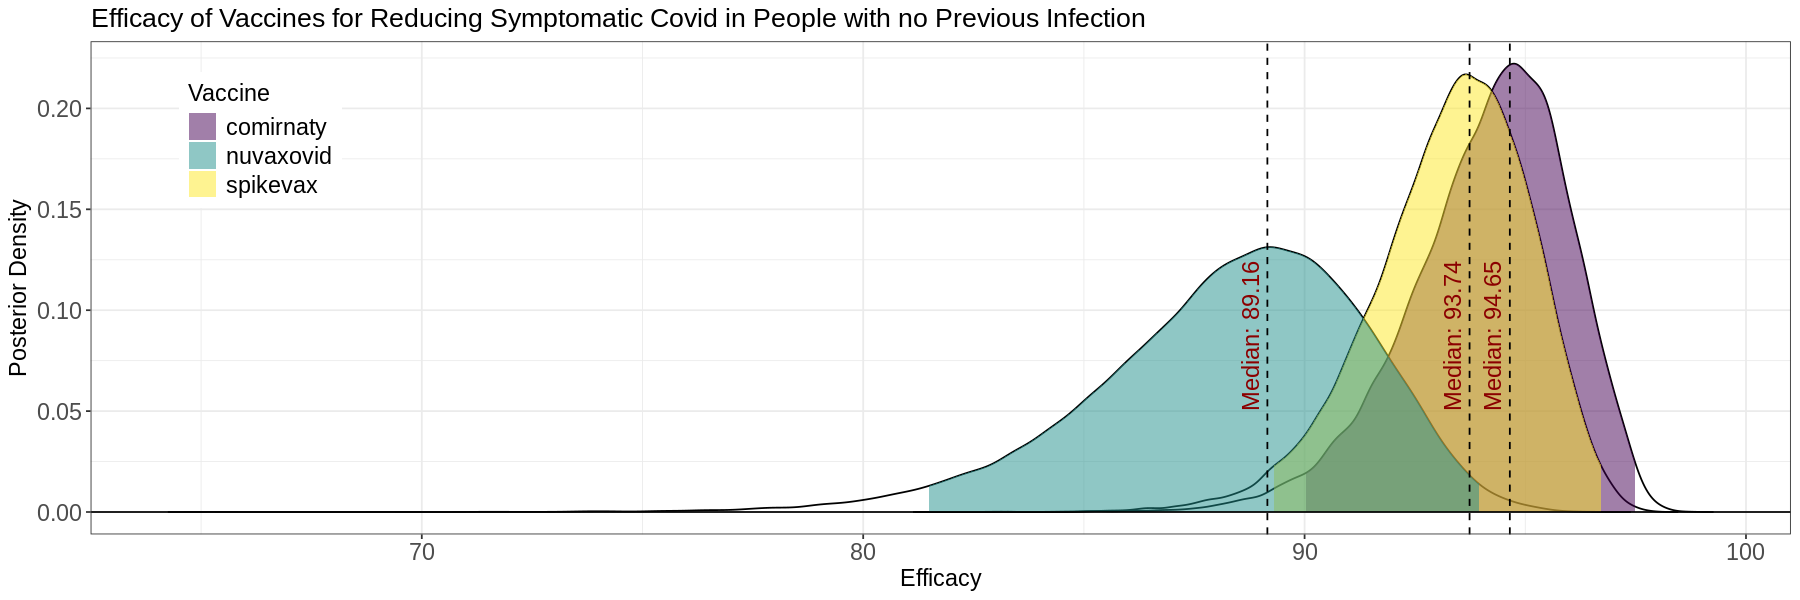

In [27]:
library(ggplot2)
library(viridis)

options(repr.plot.width=15, repr.plot.height=5)

ggplot() +
  geom_line(data = data, aes(x = efficacy_comirnaty, y = density_comirnaty), color = "black") +
  geom_line(data = data, aes(x = efficacy_nuvaxovid, y = density_nuvaxovid), color = "black") +
  geom_line(data = data, aes(x = efficacy_spikevax, y = density_spikevax), color = "black") +

  geom_ribbon(data = subset(data, efficacy_comirnaty >= comirnaty.lower & efficacy_comirnaty <= comirnaty.upper),
              aes(x = efficacy_comirnaty, ymin = 0, ymax = density_comirnaty, fill = "comirnaty"), alpha = 0.5) +
  geom_ribbon(data = subset(data, efficacy_spikevax >= spikevax.lower & efficacy_spikevax <= spikevax.upper),
              aes(x = efficacy_spikevax, ymin = 0, ymax = density_spikevax, fill = "spikevax"), alpha = 0.5) +
  geom_ribbon(data = subset(data, efficacy_nuvaxovid >= nuvaxovid.lower & efficacy_nuvaxovid <= nuvaxovid.upper),
              aes(x = efficacy_nuvaxovid, ymin = 0, ymax = density_nuvaxovid, fill = "nuvaxovid"), alpha = 0.5) +

  geom_hline(yintercept = 0, linetype = "solid", color = "black") +
  geom_vline(xintercept = comirnaty.median, linetype = "dashed", color = "black") +
  geom_vline(xintercept = nuvaxovid.median, linetype = "dashed", color = "black") +
  geom_vline(xintercept = spikevax.median, linetype = "dashed", color = "black") +

  annotate(geom = "text", x = comirnaty.median, y = 0.05, label = paste("Median:", round(comirnaty.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle = 90) +
  annotate(geom = "text", x = nuvaxovid.median, y = 0.05, label = paste("Median:", round(nuvaxovid.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle = 90) +
  annotate(geom = "text", x = spikevax.median, y = 0.05, label = paste("Median:", round(spikevax.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle = 90) +

  labs(x = "Efficacy", y = "Posterior Density",
       title = "Efficacy of Vaccines for Reducing Symptomatic Covid in People with no Previous Infection", fill = "Vaccine") +
  scale_fill_manual(values = c("comirnaty" = viridis(3)[1],
                               "nuvaxovid" = viridis(3)[2],
                               "spikevax" = viridis(3)[3])) +
  theme_bw() +
  theme(plot.title = element_text(size = 16),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        legend.position = c(0.1, 0.8))


Observe how the nuvaxovid median value falls outisde of the 95% confidence interval of the other two indicating that is a less efficient vaccine.

## Efficiency of Vaccines for Preventing Severe Covid in Infected Patients

### Xevudy

Xevudy is a medicine used for treating COVID-19 in adults and adolescents. A main study involving 1,057 patients with COVID-19 and at least one underlying condition putting them at risk of severe COVID-19 showed that Xevudy led to fewer patients requiring hospitalisation or dying within 29 days of treatment when compared with placebo. Of the patients at increased risk of their illness becoming severe, 1% of those treated with Xevudy (6 out 528) were hospitalised for longer than 24 hours within 29 days of treatment compared with 6% of patients on placebo (30 out of 529), 2 of whom died. So the efficiency is 80%.

In [28]:
vacc.tot <- 528
pla.tot <- 529
vacc.pos <- 6
pla.pos <- 30
xevudy.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.pos, pla.pos=pla.pos)
table(xevudy.tb[[1]], xevudy.tb[[2]])

            
             Neg Pos
  Placebo    499  30
  Vaccinated 522   6

In [29]:
modelFile <- model.betaprior(alpha = 1, beta = 1)
post.xevudy <- create_samples(xevudy.tb, modelFile=modelFile)

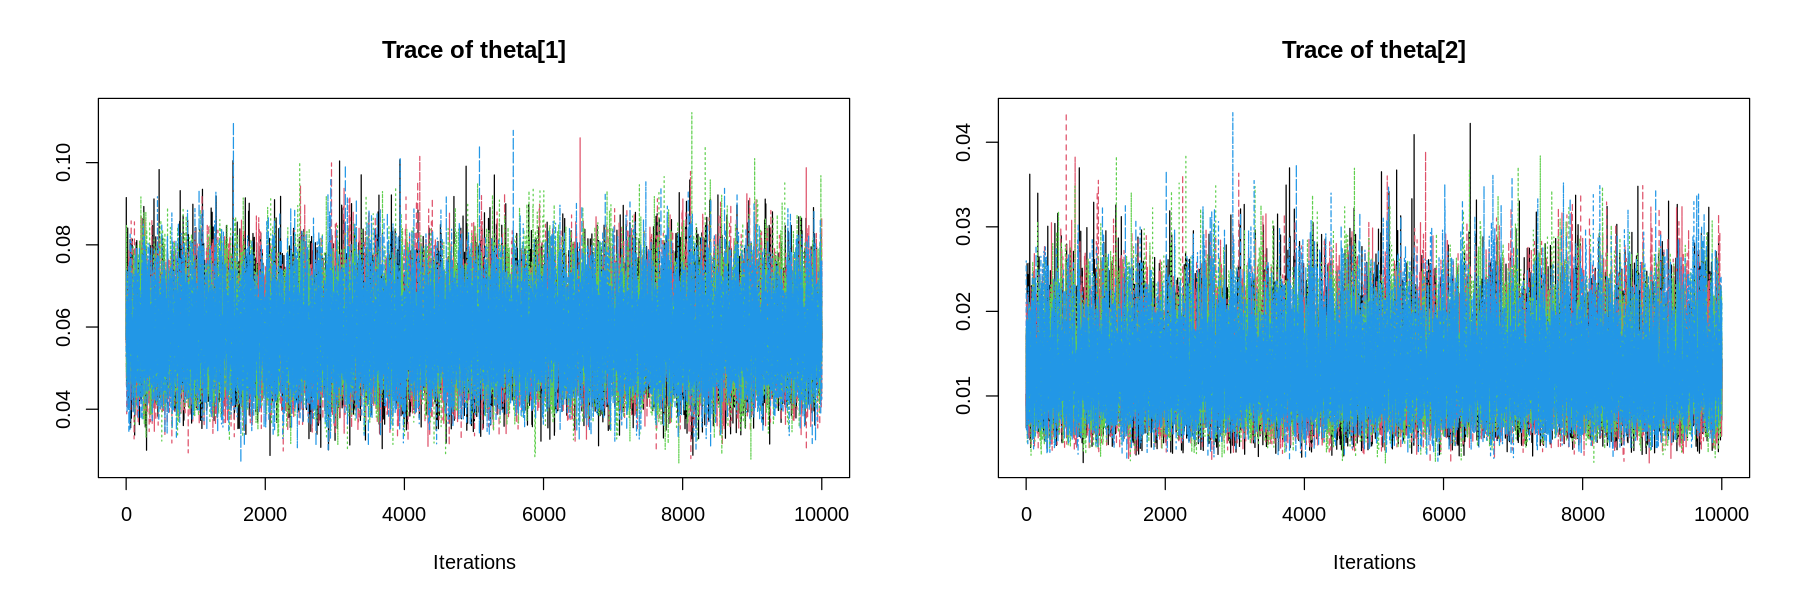

In [30]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.xevudy)

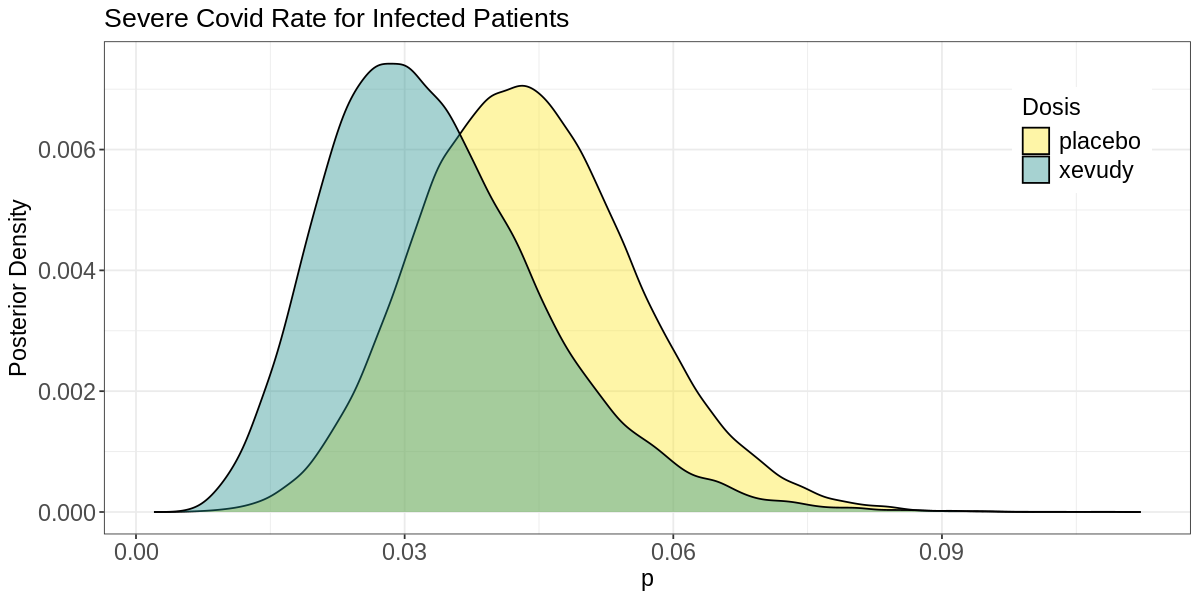

In [31]:
placebo <- unlist(post.xevudy[, "theta[1]"])
vaccine <- unlist(post.xevudy[, "theta[2]"])
lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)

p = seq(from = lower_p, to = upper_p, length.out = 512)
xevudy.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
xevudy = density(vaccine)$y / sum(density(vaccine)$y))

options(repr.plot.width=10, repr.plot.height=5)
posterior_plots(xevudy.data, title="Severe Covid Rate for Infected Patients", vaccine = "xevudy")

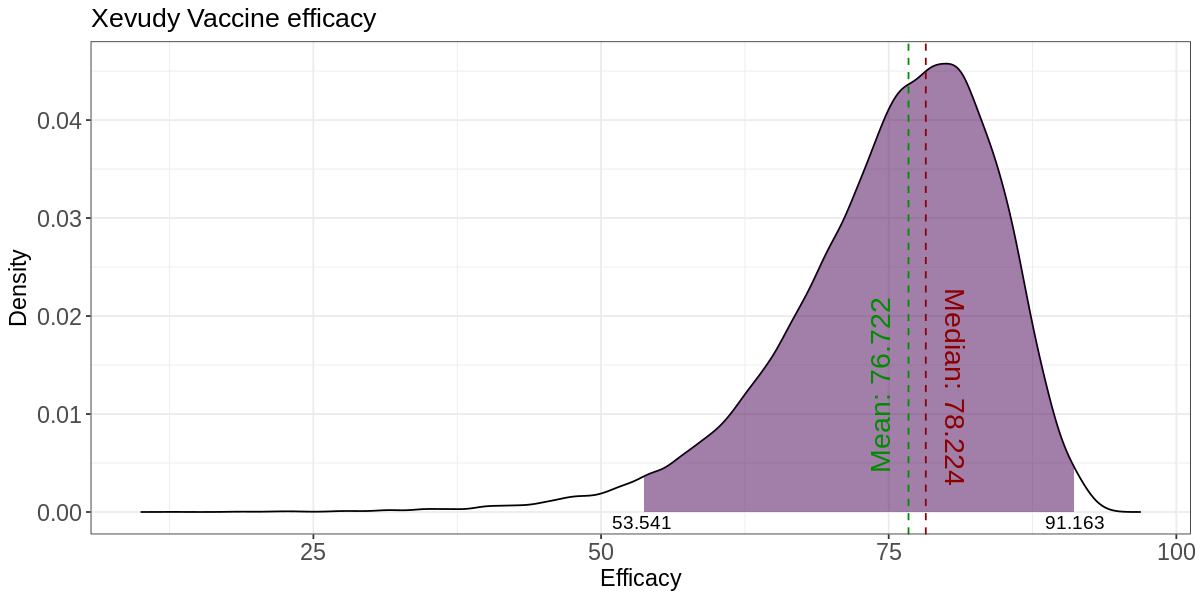

In [32]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)

efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)

xevudy.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)

xevudy.mean <- mean(vaccine.efficacy)
xevudy.median <- quantile(vaccine.efficacy, 0.5)[[1]]
xevudy.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
xevudy.upper <- quantile(vaccine.efficacy, 0.975)[[1]]

efficacy_plot(xevudy.data, xevudy.lower, xevudy.upper, xevudy.mean, xevudy.median, title = "Xevudy Vaccine efficacy")

We observed that for the xevudy vaccine we obtain a mean efficiency of 76.7% with respect to the placebo results with respect to the number of patients requiring hospitalization. The clinical data

In [33]:
xevudy.trial <- 80.0

xevudy.results <- data.frame(mean = xevudy.mean, median=xevudy.median,
trial = xevudy.trial, lower_interval = xevudy.lower,
upper_interval = xevudy.upper); xevudy.results

mean     median   trial lower_interval upper_interval
1 76.72217 78.22421 80    53.54082       91.16281

### Ronapreve

A main study involving patients with COVID-19 who did not require oxygen and were at increased risk of their illness becoming severe showed that Ronapreve at the authorised dose led to fewer hospitalisations or deaths when compared with placebo (dummy treatment). Overall, 0.9% of
patients treated with Ronapreve (11 out of 1,192 patients) were hospitalised or died within 29 days of treatment compared with 3.4% of patients on placebo (40 out of 1,193 patients). The efficiency is 72.5%

In [34]:
vacc.tot <- 1192
pla.tot <- 1193
vacc.severe <- 11
pla.severe <- 40
ronapreve_treatment.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.severe, pla.pos=pla.severe)

table(ronapreve_treatment.tb[[1]], ronapreve_treatment.tb[[2]])

            
              Neg  Pos
  Placebo    1153   40
  Vaccinated 1181   11

In [35]:
modelFile <- model.betaprior(alpha = 1, beta = 1)
post.ronapreve_treatment <- create_samples(ronapreve_treatment.tb, modelFile=modelFile)

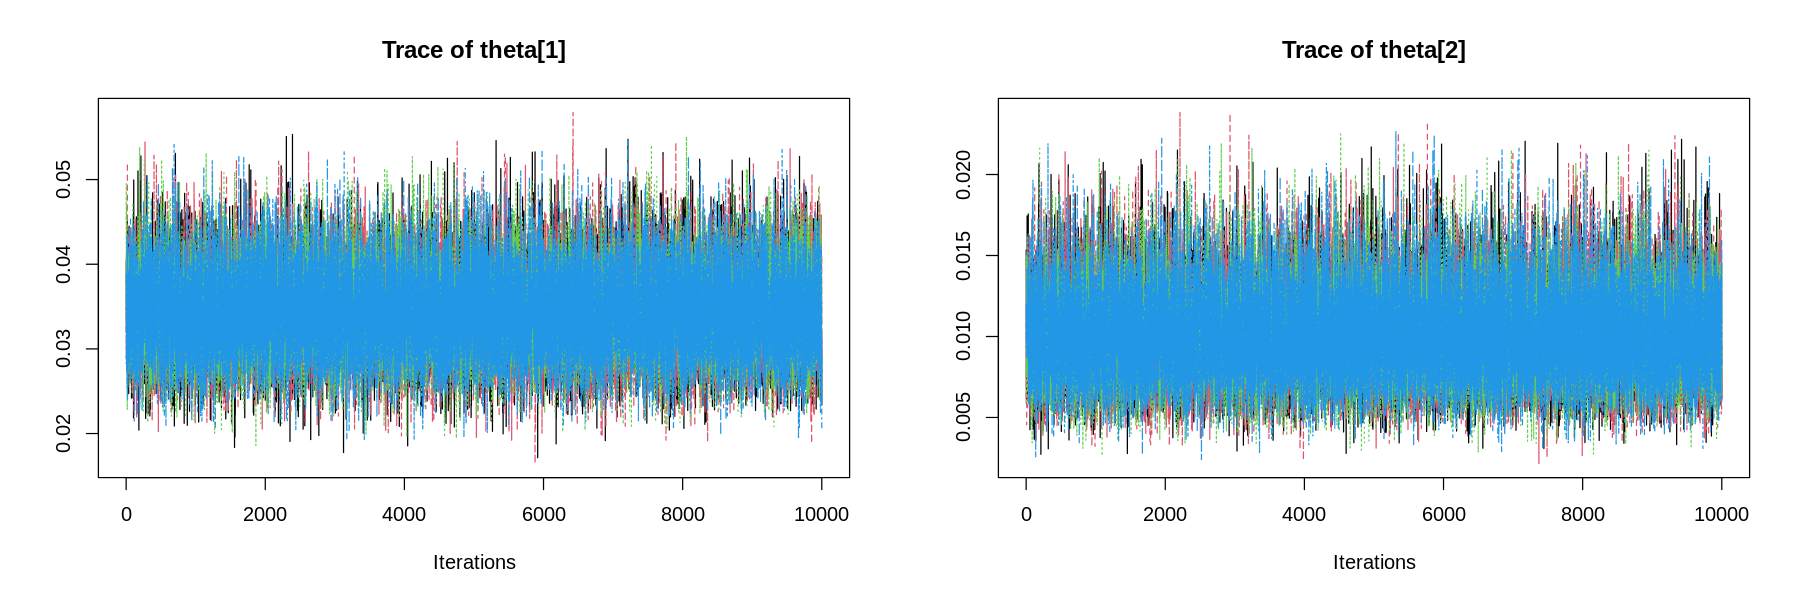

In [36]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.ronapreve_treatment)

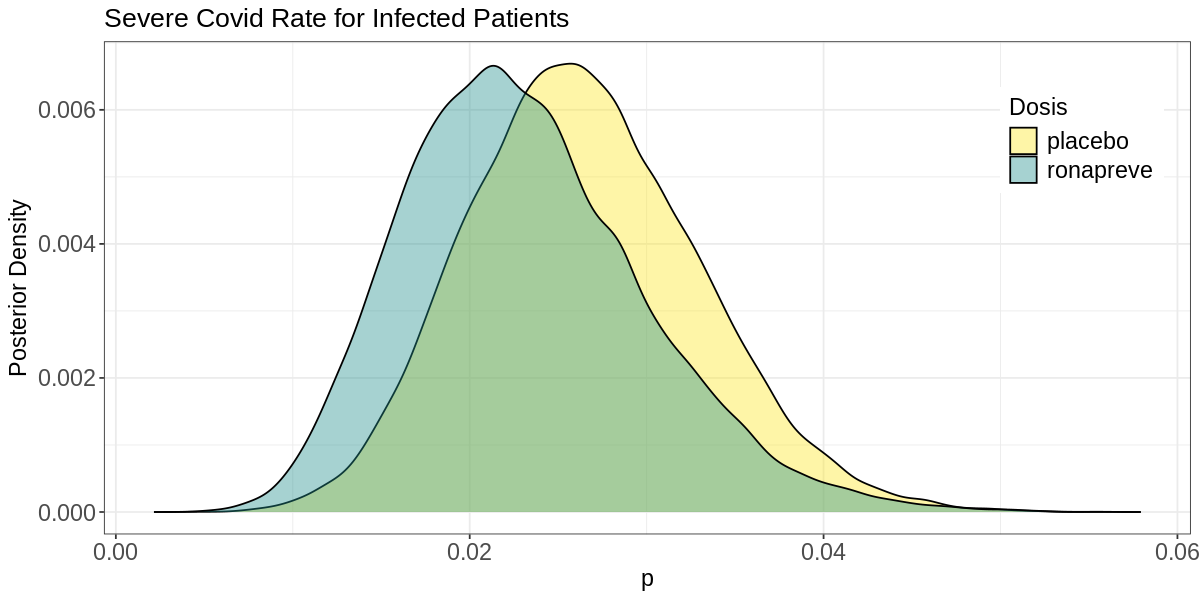

In [37]:
placebo <- unlist(post.ronapreve_treatment[, "theta[1]"])
vaccine <- unlist(post.ronapreve_treatment[, "theta[2]"])

lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)
p = seq(from = lower_p, to = upper_p, length.out = 512)

ronapreve_treatment.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
ronapreve = density(vaccine)$y / sum(density(vaccine)$y))

options(repr.plot.width=10, repr.plot.height=5)
posterior_plots(ronapreve_treatment.data, title="Severe Covid Rate for Infected Patients", vaccine = "ronapreve")

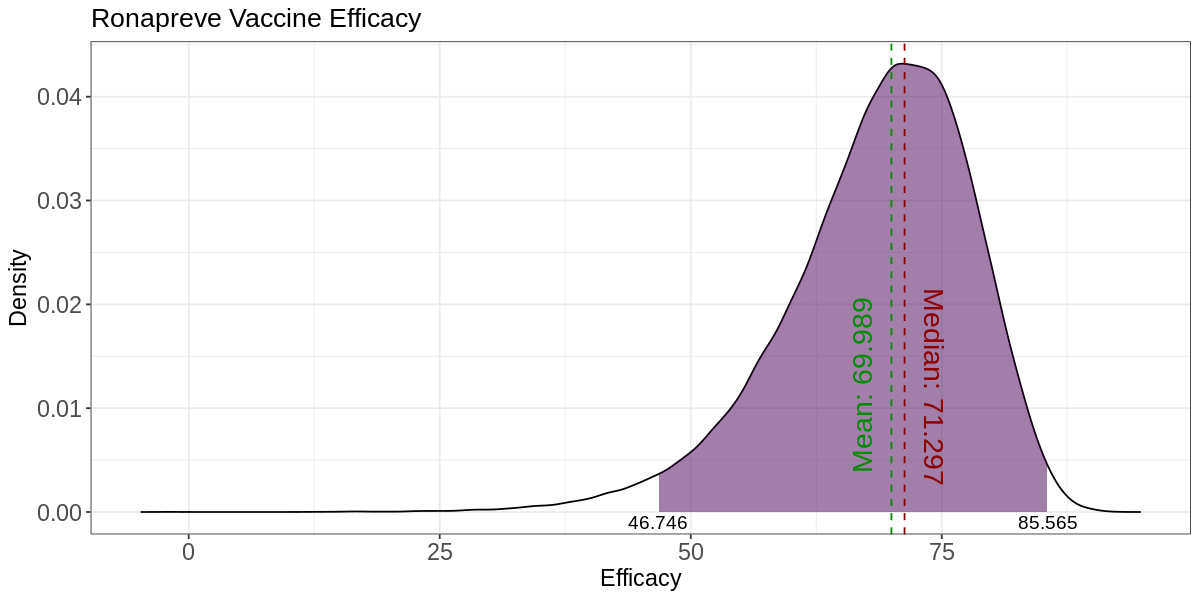

In [38]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)

efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)

ronapreve_treatment.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)

ronapreve_treatment.mean <- mean(vaccine.efficacy)
ronapreve_treatment.median <- quantile(vaccine.efficacy, 0.5)[[1]]
ronapreve_treatment.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
ronapreve_treatment.upper <- quantile(vaccine.efficacy, 0.975)[[1]]

efficacy_plot(ronapreve_treatment.data, ronapreve_treatment.lower, ronapreve_treatment.upper,
ronapreve_treatment.mean, ronapreve_treatment.median, title = "Ronapreve Vaccine Efficacy")

We can see that in the case of treatment the ronapreve vaccine gets a mean 70% increase in efficiency with respect to the placebo results for the hospitalizations of already infected patients. The 95% confidence interval ranges from 47.1% to 85.6% which includes the claimed efficiency of 72.5% of the clinical trials.

In [39]:
ronapreve_treatment.trial <- 72.5

ronapreve_treatment.results <- data.frame(mean = ronapreve_treatment.mean, median=ronapreve_treatment.median,
trial = ronapreve_treatment.trial, lower_interval = ronapreve_treatment.lower, upper_interval = ronapreve_treatment.upper); ronapreve_treatment.results

mean     median   trial lower_interval upper_interval
1 69.98884 71.29741 72.5  46.74559       85.56539

### Comparision Between Xevudy vs Ronapreve

Both Xevudy and Ronapreve vaccines efficiency have been tested using covid patients at risk of their illness becoming severe overviewing the difference in which symptomatic covid arises between vaccinated and unvaccinated patients. The results are:

In [40]:
results <- rbind(xevudy.results, ronapreve_treatment.results)

row.names(results) <- c("Xevudy", "Ronapreve"); results

results <- results %>% arrange(desc(median))



mean     median   trial lower_interval upper_interval
Xevudy    76.72217 78.22421 80.0  53.54082       91.16281      
Ronapreve 69.98884 71.29741 72.5  46.74559       85.56539

In [41]:
data <- data.frame(efficacy_xevudy = xevudy.data$efficacy, density_xevudy = xevudy.data$density,
                  efficacy_ronapreve = ronapreve_treatment.data$efficacy, density_ronapreve = ronapreve_treatment.data$density)

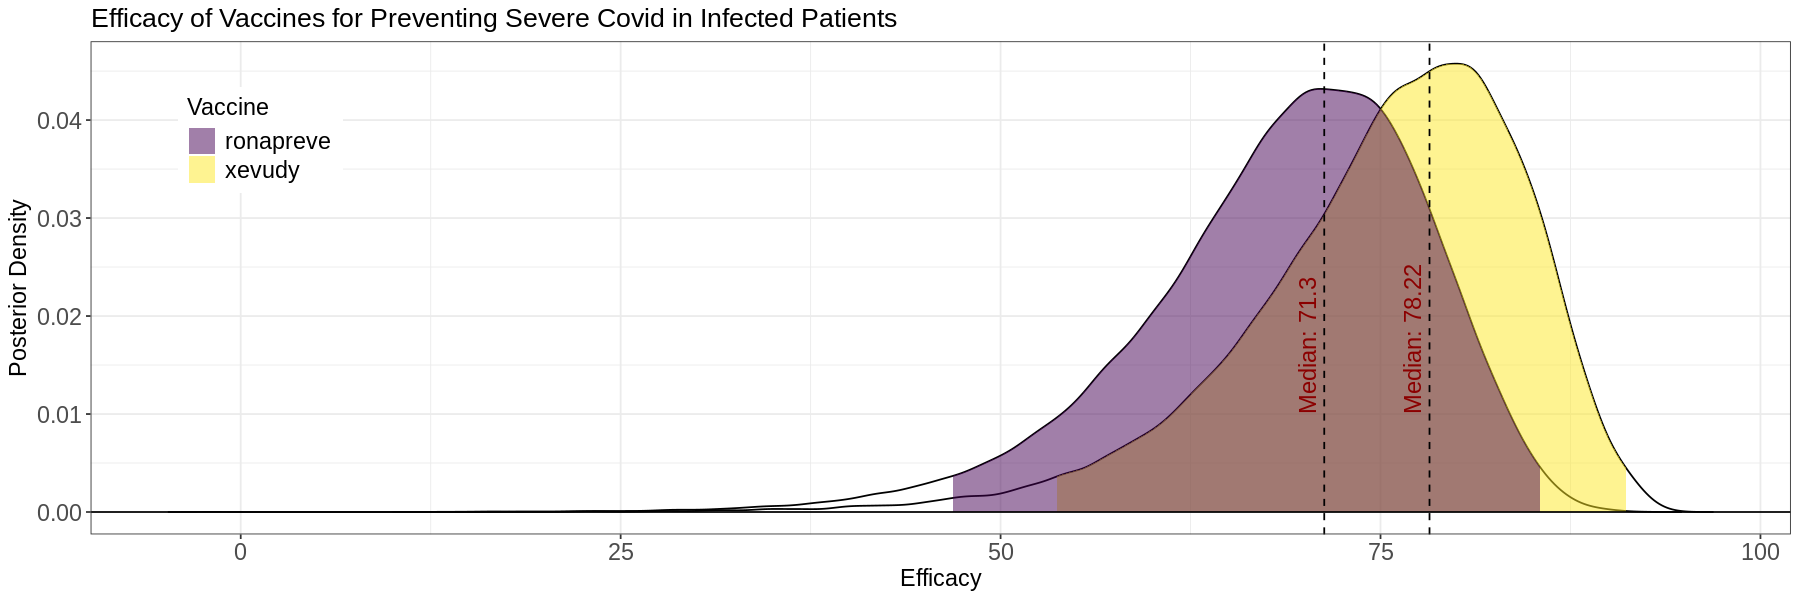

In [42]:
options(repr.plot.width=15, repr.plot.height=5)

ggplot() +
  # Lines for density plots
  geom_line(data = data, aes(x = efficacy_xevudy, y = density_xevudy), color = "black") +
  geom_line(data = data, aes(x = efficacy_ronapreve, y = density_ronapreve), color = "black") +

  # Ribbons for shaded areas
  geom_ribbon(data = subset(data, efficacy_xevudy >= xevudy.lower & efficacy_xevudy <= xevudy.upper),
              aes(x = efficacy_xevudy, ymin = 0, ymax = density_xevudy, fill = "xevudy"), alpha = 0.5) +
  geom_ribbon(data = subset(data, efficacy_ronapreve >= ronapreve_treatment.lower & efficacy_ronapreve <= ronapreve_treatment.upper),
              aes(x = efficacy_ronapreve, ymin = 0, ymax = density_ronapreve, fill = "ronapreve"), alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black") +

  geom_vline(xintercept = xevudy.median, linetype = "dashed", color = "black") +
  geom_vline(xintercept = ronapreve_treatment.median, linetype = "dashed", color = "black") +

  annotate(geom = "text", x = xevudy.median, y = 0.01, label = paste("Median:", round(xevudy.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle=90) +
  annotate(geom = "text", x = ronapreve_treatment.median, y = 0.01, label = paste("Median:", round(ronapreve_treatment.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle=90) +


  # Labels and theme
  labs(x = "Efficacy", y = "Posterior Density",
  title = "Efficacy of Vaccines for Preventing Severe Covid in Infected Patients", fill = "Vaccine") +
  scale_fill_manual(values = viridis(2)) +
  theme_bw() +
  theme(plot.title = element_text(size = 16),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        legend.position = c(0.1, 0.8))

Both vaccines work with similar efficiency

## Ronapreve Vaccine Efficiency for Preventing Covid Symptoms in Patients who has a Household Member Infected

A main study looked at the benefits of Ronapreve for prevention of COVID-19 in people who had close contact with an infected household member.



### Negative Test Result

Amongst people who tested negative for SARS-CoV-2 following contact, fewer people given Ronapreve developed symptoms within 29 days of their test results compared with people given placebo (1.5% (11 out of 753) for Ronapreve compared with 7.8% (59 out of 752 people) for placebo). Efficiency 81.3%

In [43]:
vacc.tot <- 753
pla.tot <- 752
vacc.pos <- 11
pla.pos <- 59

ronapreve_prev_neg.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.pos, pla.pos=pla.pos)

table(ronapreve_prev_neg.tb[[1]], ronapreve_prev_neg.tb[[2]])

            
             Neg Pos
  Placebo    693  59
  Vaccinated 742  11

In [44]:
modelFile <- model.betaprior(alpha = 1, beta = 1)
post.ronapreve_prev_neg <- create_samples(ronapreve_prev_neg.tb, modelFile=modelFile)

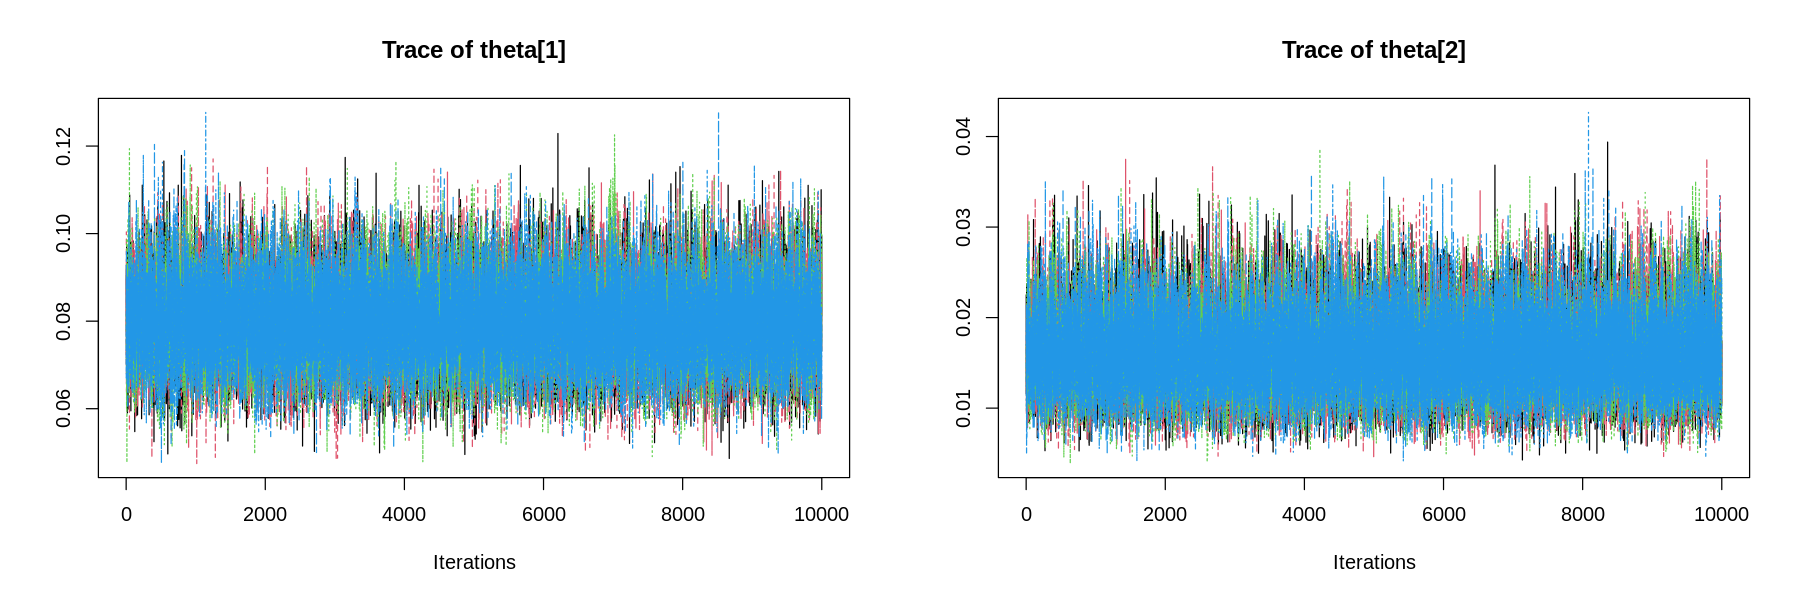

In [45]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.ronapreve_prev_neg)

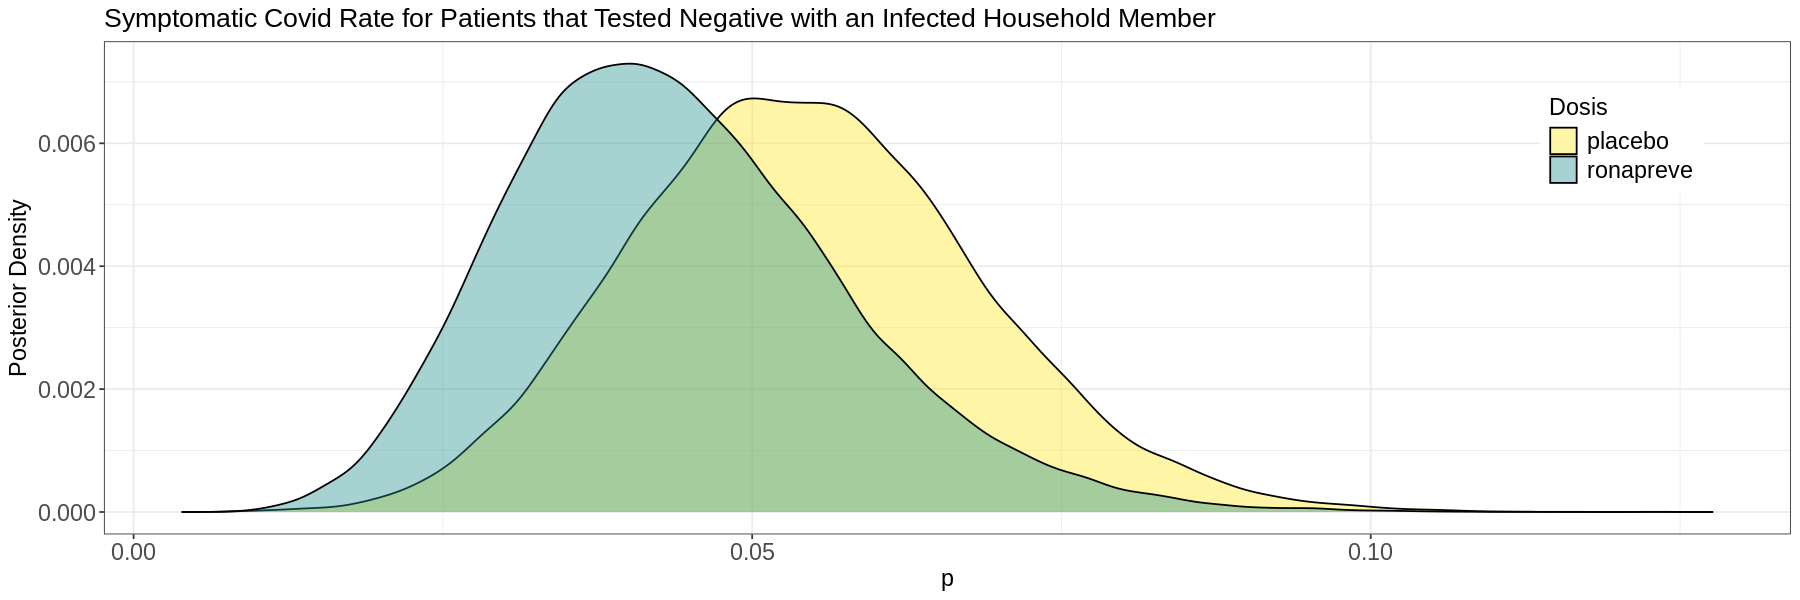

In [46]:
placebo <- unlist(post.ronapreve_prev_neg[, "theta[1]"])
vaccine <- unlist(post.ronapreve_prev_neg[, "theta[2]"])
lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)

p = seq(from = lower_p, to = upper_p, length.out = 512)
ronapreve_prev_neg.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
ronapreve = density(vaccine)$y / sum(density(vaccine)$y))

options(repr.plot.width=15, repr.plot.height=5)
posterior_plots(ronapreve_prev_neg.data, title="Symptomatic Covid Rate for Patients that Tested Negative with an Infected Household Member", vaccine = "ronapreve")

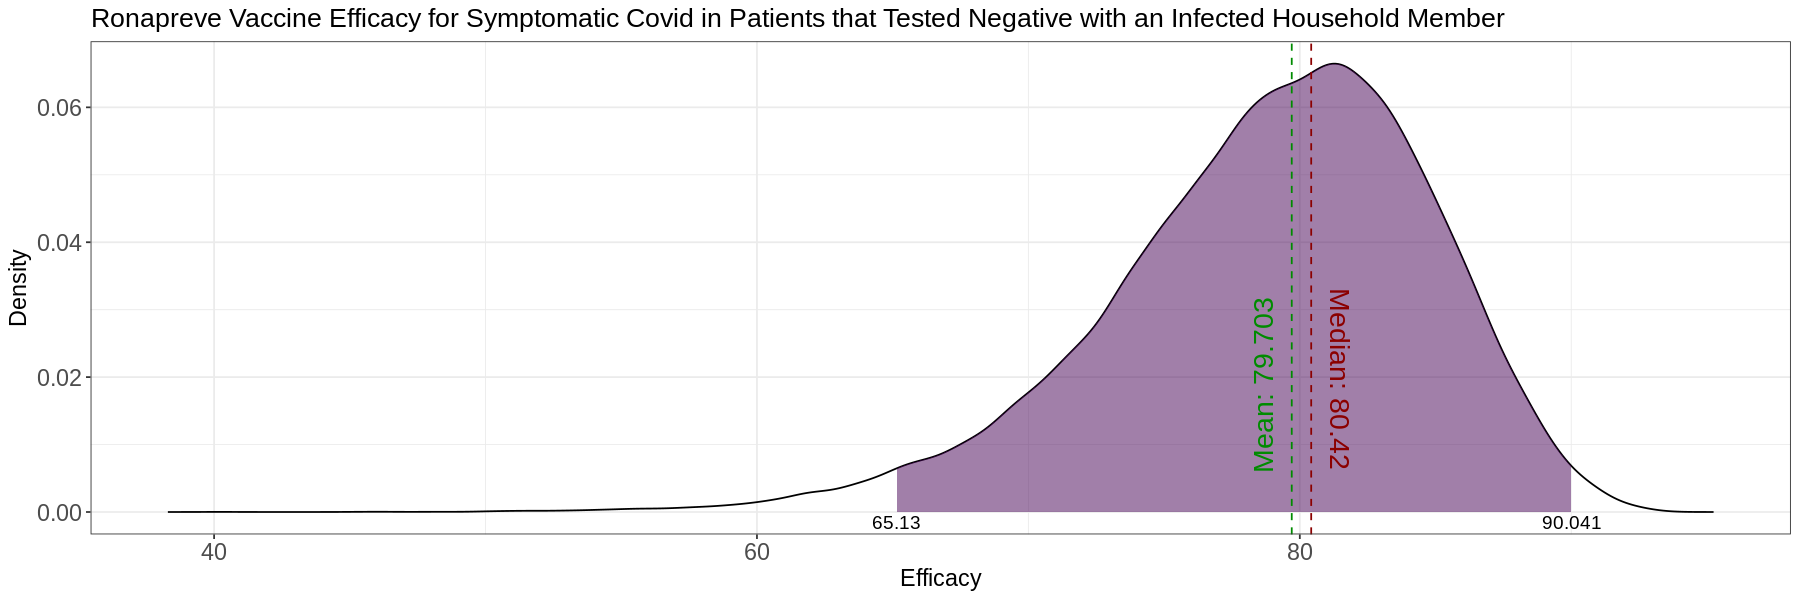

In [47]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)

efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)

ronapreve_prev_neg.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)

ronapreve_prev_neg.mean <- mean(vaccine.efficacy)
ronapreve_prev_neg.median <- quantile(vaccine.efficacy, 0.5)[[1]]
ronapreve_prev_neg.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
ronapreve_prev_neg.upper <- quantile(vaccine.efficacy, 0.975)[[1]]

efficacy_plot(ronapreve_prev_neg.data, ronapreve_prev_neg.lower, ronapreve_prev_neg.upper,
 ronapreve_prev_neg.mean, ronapreve_prev_neg.median, title = "Ronapreve Vaccine Efficacy for Symptomatic Covid in Patients that Tested Negative with an Infected Household Member")

We can see that in the case of prevention for people that tested negative we get a mean of 79.7% increase in the efficiency with respect to the placebo results. The 95% confidence interval ranges from 65.1% to 90.0% where the trial efficiency of 81.3% falls within.

In [48]:
ronapreve_prev_neg.trial <- 81.3

ronapreve_prev_neg.results <- data.frame(mean = ronapreve_prev_neg.mean, median=ronapreve_prev_neg.median, trial = ronapreve_prev_neg.trial,
lower_interval = ronapreve_prev_neg.lower, upper_interval = ronapreve_prev_neg.upper); ronapreve_prev_neg.results

mean     median   trial lower_interval upper_interval
1 79.70272 80.41951 81.3  65.13019       90.04057

### Positive Test Result

Ronapreve was also found to be effective at preventing symptoms in infected people. Amongst the people who tested positive for SARS-CoV-2 after contact, 29% (29 out of 100) of people who received Ronapreve developed symptoms compared with 42.3% (44 out of 104 people) of people who received a placebo.


In [49]:
vacc.tot <- 100
pla.tot <- 104
vacc.pos <- 29
pla.pos <- 44

ronapreve_prev_pos.tb <- vaccine.info(vacc.tot = vacc.tot, pla.tot=pla.tot, vacc.pos=vacc.pos, pla.pos=pla.pos)

table(ronapreve_prev_pos.tb[[1]], ronapreve_prev_pos.tb[[2]])

            
             Neg Pos
  Placebo     60  44
  Vaccinated  71  29

In [50]:
modelFile <- model.betaprior(alpha = 1, beta = 1)
post.ronapreve_prev_pos <- create_samples(ronapreve_prev_pos.tb, modelFile=modelFile)

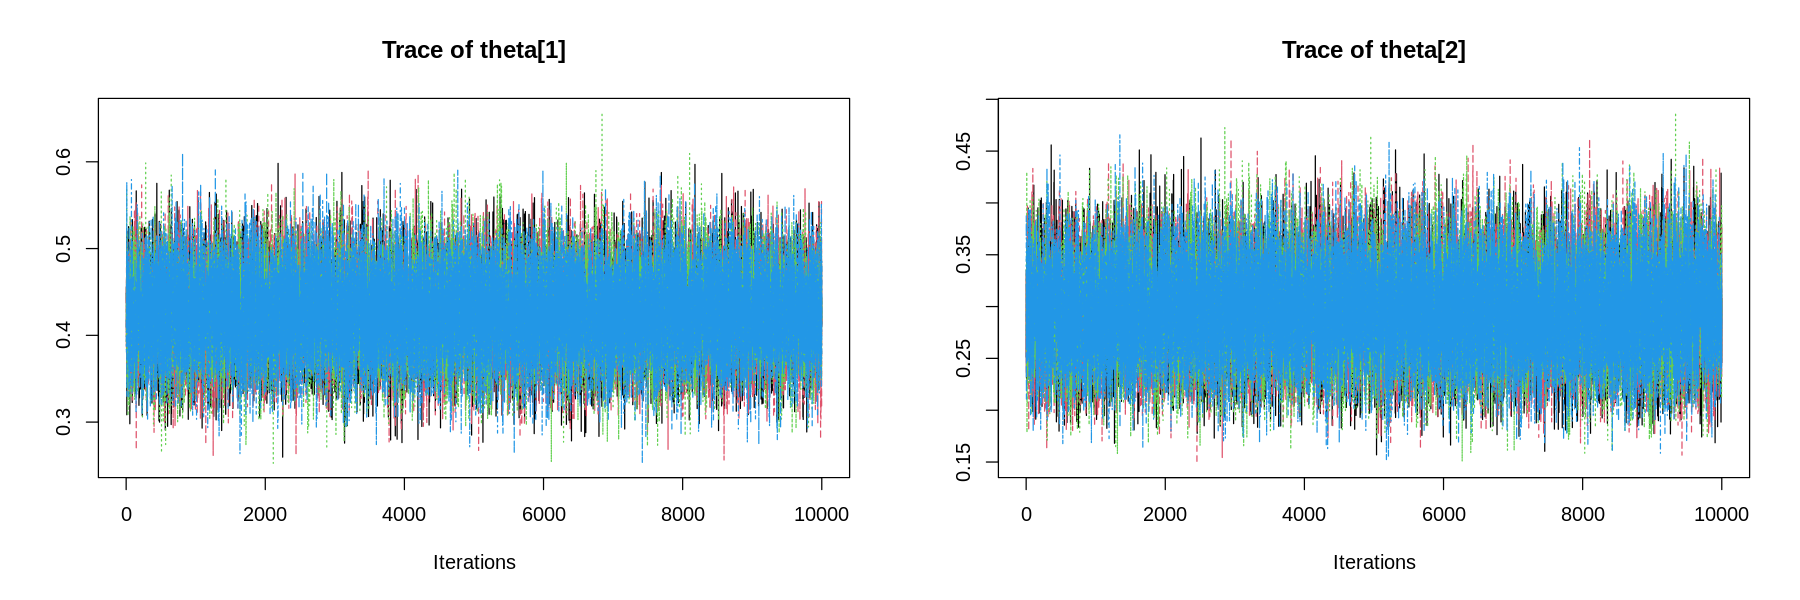

In [51]:
# traceplots to ensure convergence and stationarity

par(mfrow = c(1, 2))
options(repr.plot.width=15, repr.plot.height=5)

traceplot(post.ronapreve_prev_pos)

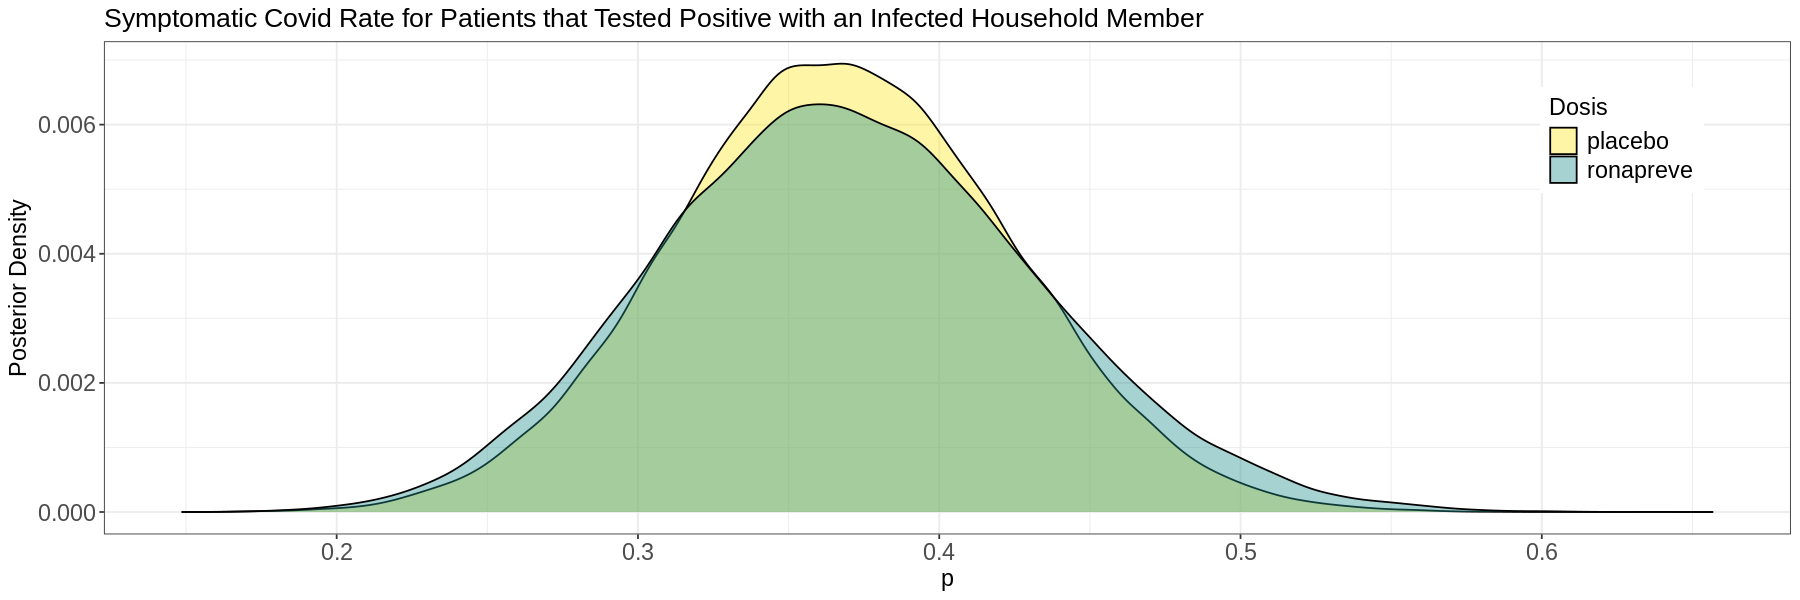

In [52]:
placebo <- unlist(post.ronapreve_prev_pos[, "theta[1]"])
vaccine <- unlist(post.ronapreve_prev_pos[, "theta[2]"])
lower_p <- min(placebo, vaccine)
upper_p <- max(placebo, vaccine)

p = seq(from = lower_p, to = upper_p, length.out = 512)
ronapreve_prev_pos.data <- data.frame(p = p, placebo = density(placebo)$y / sum(density(placebo)$y),
ronapreve = density(vaccine)$y / sum(density(vaccine)$y))

options(repr.plot.width=15, repr.plot.height=5)
posterior_plots(ronapreve_prev_pos.data, title="Symptomatic Covid Rate for Patients that Tested Positive with an Infected Household Member", vaccine = "ronapreve")

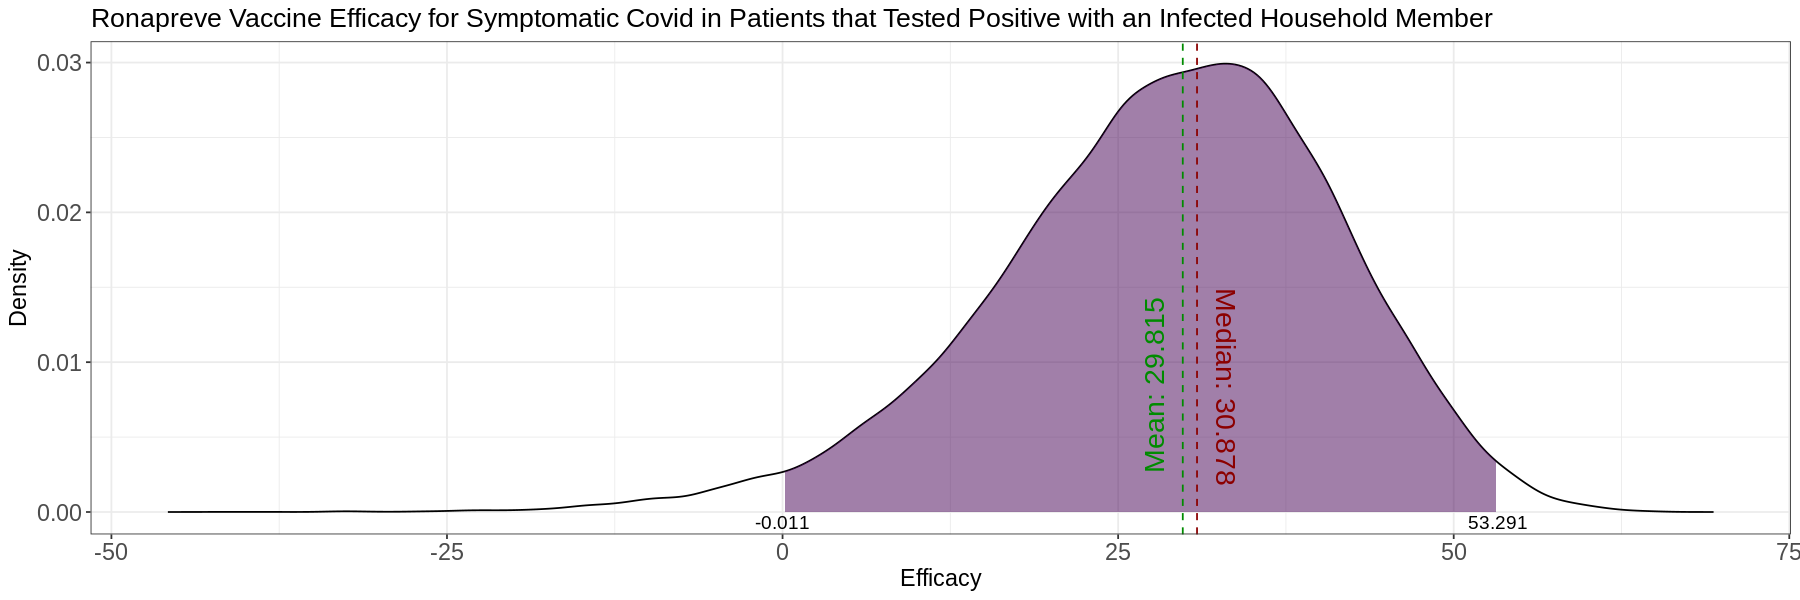

In [53]:
vaccine.efficacy <- ((placebo - vaccine) / placebo * 100)

efficacy <- seq(from = min(vaccine.efficacy), to = max(vaccine.efficacy), length.out = 512)

ronapreve_prev_pos.data <- data.frame(efficacy = efficacy, density=density(vaccine.efficacy)$y)

ronapreve_prev_pos.mean <- mean(vaccine.efficacy)
ronapreve_prev_pos.median <- quantile(vaccine.efficacy, 0.5)[[1]]
ronapreve_prev_pos.lower <- quantile(vaccine.efficacy, 0.025)[[1]]
ronapreve_prev_pos.upper <- quantile(vaccine.efficacy, 0.975)[[1]]

efficacy_plot(ronapreve_prev_pos.data, ronapreve_prev_pos.lower, ronapreve_prev_pos.upper,
 ronapreve_prev_pos.mean, ronapreve_prev_pos.median, title = "Ronapreve Vaccine Efficacy for Symptomatic Covid in Patients that Tested Positive with an Infected Household Member")

We can see that in the case of prevention for people that tested positive the efficiency is not very high we have a mean of 29.5% increase in the efficiency with respect to the placebo results. The 95% confidence interval for the efficiency ranges from 0% to 53% in which the trial efficiency 31.5% falls within.

In [54]:
ronapreve_prev_pos.trial <- 31.5

ronapreve_prev_pos.results <- data.frame(mean = ronapreve_prev_pos.mean, median=ronapreve_prev_pos.median, trial = ronapreve_prev_pos.trial,
lower_interval = ronapreve_prev_pos.lower, upper_interval = ronapreve_prev_pos.upper); ronapreve_prev_pos.results

mean     median   trial lower_interval upper_interval
1 29.81535 30.87758 31.5  -0.01094377    53.29138

### Comparision in the Ronapreve Efficiency for Positive and Negative Testing Results

In [55]:
results <- rbind(ronapreve_prev_neg.results, ronapreve_prev_pos.results)

row.names(results) <- c("Negative Test", "Positive Test"); results

results <- results %>% arrange(desc(median))

mean     median   trial lower_interval upper_interval
Negative Test 79.70272 80.41951 81.3  65.13019132    90.04057      
Positive Test 29.81535 30.87758 31.5  -0.01094377    53.29138

In [56]:
data <- data.frame(efficacy_test_neg = ronapreve_prev_neg.data$efficacy, density_test_neg = ronapreve_prev_neg.data$density,
                  efficacy_test_pos = ronapreve_prev_pos.data$efficacy, density_test_pos = ronapreve_prev_pos.data$density)

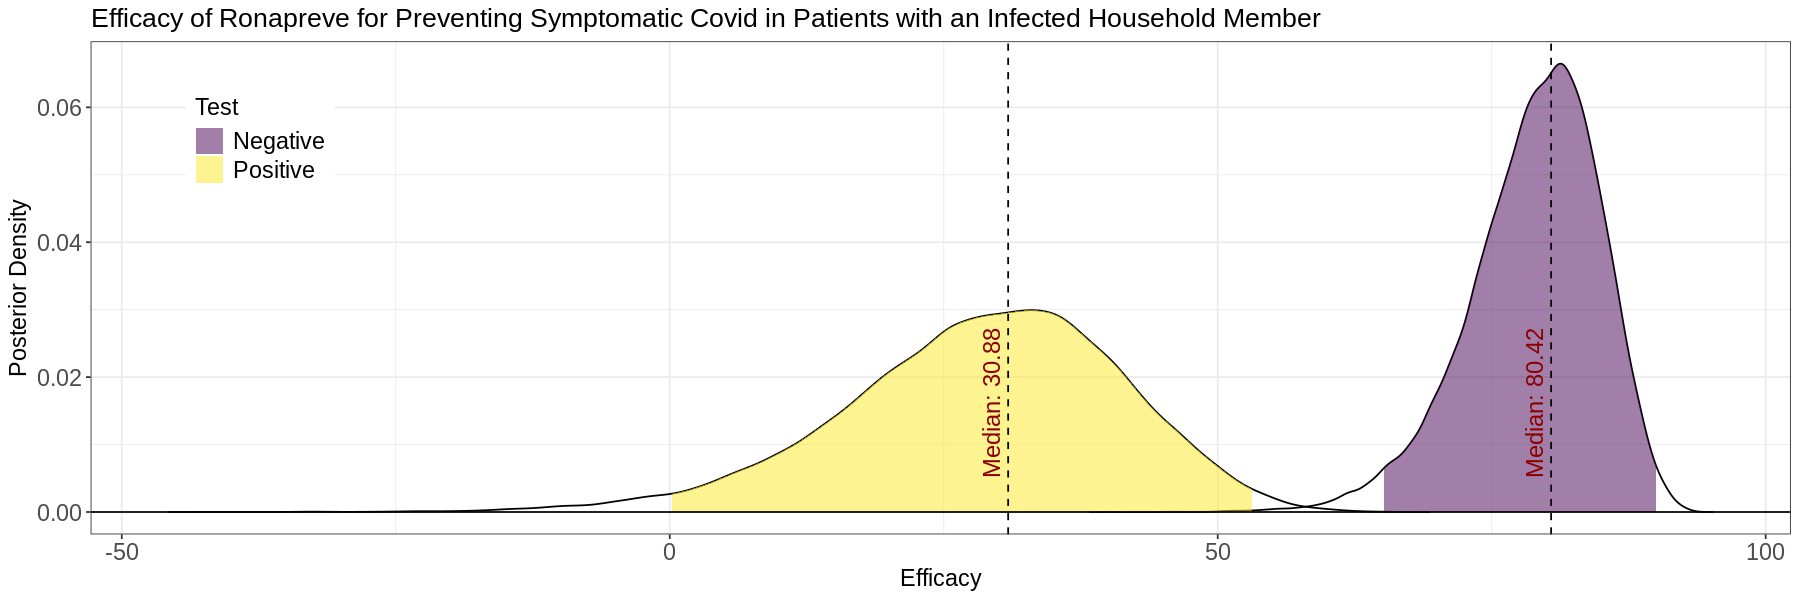

In [57]:
options(repr.plot.width=15, repr.plot.height=5)

ggplot() +
  # Lines for density plots
  geom_line(data = data, aes(x = efficacy_test_neg, y = density_test_neg), color = "black") +
  geom_line(data = data, aes(x = efficacy_test_pos, y = density_test_pos), color = "black") +

  # Ribbons for shaded areas
  geom_ribbon(data = subset(data, efficacy_test_neg >= ronapreve_prev_neg.lower & efficacy_test_neg <= ronapreve_prev_neg.upper),
              aes(x = efficacy_test_neg, ymin = 0, ymax = density_test_neg, fill = "Negative"), alpha = 0.5) +
  geom_ribbon(data = subset(data, efficacy_test_pos >= ronapreve_prev_pos.lower & efficacy_test_pos <= ronapreve_prev_pos.upper),
              aes(x = efficacy_test_pos, ymin = 0, ymax = density_test_pos, fill = "Positive"), alpha = 0.5) +
  geom_hline(yintercept = 0, linetype = "solid", color = "black") +

  geom_vline(xintercept = ronapreve_prev_neg.median, linetype = "dashed", color = "black") +
  geom_vline(xintercept = ronapreve_prev_pos.median, linetype = "dashed", color = "black") +

  annotate(geom = "text", x = ronapreve_prev_neg.median, y = 0.005, label = paste("Median:",
            round(ronapreve_prev_neg.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle=90) +
  annotate(geom = "text", x = ronapreve_prev_pos.median, y = 0.005, label = paste("Median:",
           round(ronapreve_prev_pos.median, 2)), vjust = -0.5, hjust = 0, size = 5, color = "red4", angle=90) +


  # Labels and theme
  labs(x = "Efficacy", y = "Posterior Density",
  title = "Efficacy of Ronapreve for Preventing Symptomatic Covid in Patients with an Infected Household Member", fill = "Test") +
  scale_fill_manual(values = viridis(2)) +
  theme_bw() +
  theme(plot.title = element_text(size = 16),
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 14),
        legend.text = element_text(size = 14),
        legend.title = element_text(size = 14),
        legend.position = c(0.1, 0.8))

We observe a huge difference in performance. If the patient test positive of covid, the vaccination is less effective in preventing a symptomatic covid case.

##Vaccine Efficiency  of young people under 25

In [58]:
# Comirnaty data
tot_Comirnaty_vaccyoung <- 1005
tot_Comirnaty_placyoung <- 978

patient <- c(rep("vaccine", tot_Comirnaty_vaccyoung),
             rep("placebo", tot_Comirnaty_placyoung))

positive_Comirnaty_vaccyoung <- 0
positive_Comirnaty_placyoung <- 16

tested <- c(rep("pos", positive_Comirnaty_vaccyoung),
            rep("neg", tot_Comirnaty_vaccyoung - positive_Comirnaty_vaccyoung),
            rep("pos", positive_Comirnaty_placyoung),
            rep("neg", tot_Comirnaty_placyoung - positive_Comirnaty_placyoung))

Comirnaty_vaccyoung.tb <- tibble(tested = tested, patient = patient)

table(Comirnaty_vaccyoung.tb[[2]], Comirnaty_vaccyoung.tb[[1]])

# Data for JAGS
datalist_Comirnaty <- list(
  tested = ifelse(Comirnaty_vaccyoung.tb$tested == "neg", 0, 1),
  patient = as.integer(factor(Comirnaty_vaccyoung.tb$patient)),
  Ntot = length(Comirnaty_vaccyoung.tb$tested),
  Nclass = length(unique(Comirnaty_vaccyoung.tb$patient))
)

# Run the JAGS model
jagsModelComirnaty_vaccyoung <- jags.model(file = "/content/jags_model_beta _uniform.txt",
                                           data = datalist_Comirnaty,
                                           n.chain = 4, n.adapt = 500, quiet = TRUE)

# Update the model
update(jagsModelComirnaty_vaccyoung, n.iter = 500)


         
           neg  pos
  placebo  962   16
  vaccine 1005    0

In [59]:
codaSamples_Comirnaty <- coda.samples(jagsModelComirnaty_vaccyoung, variable.names = c("theta"),n.iter = 15000)

In [60]:
summary(codaSamples_Comirnaty)


Iterations = 501:15500
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
theta[1] 0.0173459 0.0041511 1.695e-05      1.701e-05
theta[2] 0.0009904 0.0009888 4.037e-06      4.023e-06

2. Quantiles for each variable:

              2.5%       25%       50%      75%    97.5%
theta[1] 1.023e-02 0.0143683 0.0170232 0.019951 0.026387
theta[2] 2.323e-05 0.0002855 0.0006872 0.001375 0.003652


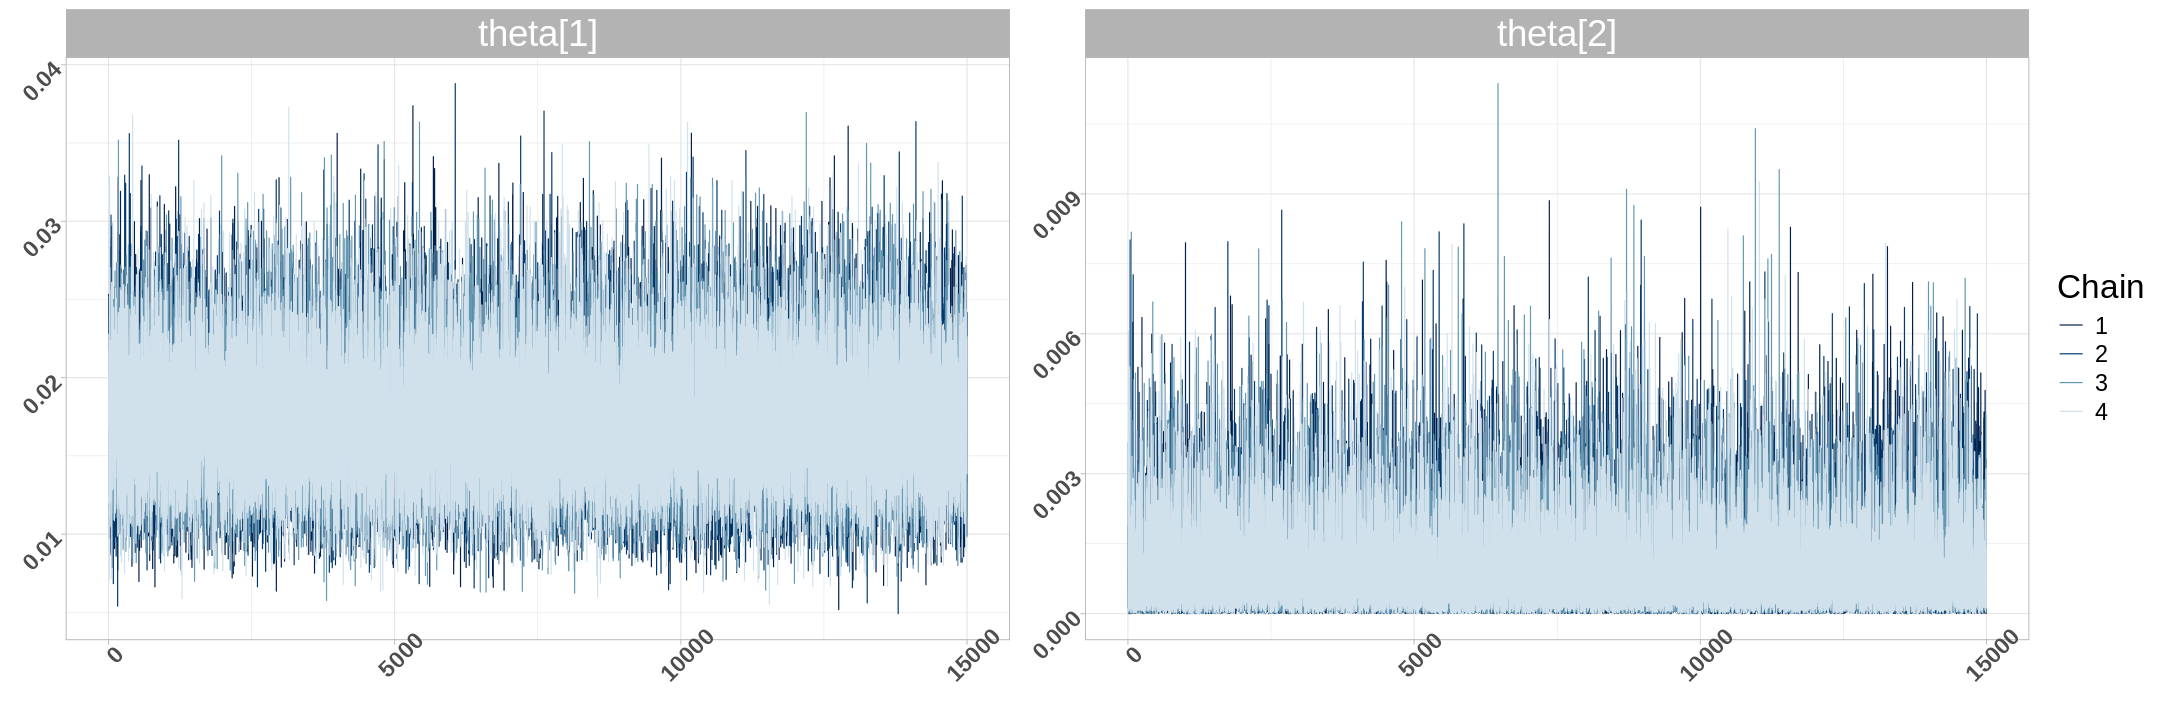

In [61]:
options(repr.plot.width = 18, repr.plot.height = 6)

p <- mcmc_trace(codaSamples_Comirnaty) +
  theme_light() +
  facet_text(size = 22) +
  theme(
    axis.text.x = element_text(face = "bold", size = 14, angle = 45),
    axis.text.y = element_text(face = "bold", size = 14, angle = 45),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 14)
  )

print(p)

In [62]:
plot_mcmc_area <- function(data, parameter, color, title, subtitle = NULL) {
  mcmc_areas(
    data,
    pars = parameter,
    prob = 0.95
  ) +
    scale_fill_manual(values = color) +
    theme_light(base_size = 14) +
    theme(
      axis.text.x = element_text(face = "bold", size = 10, angle = 45),
      axis.text.y = element_blank(),
      plot.title = element_text(size = 16, hjust = 0.5),
      plot.subtitle = element_text(size = 13, hjust = 0.5)
    ) +
    labs(
      title = title,
      subtitle = subtitle,
      x = "p",
      y = "Posterior Density"
    )
}

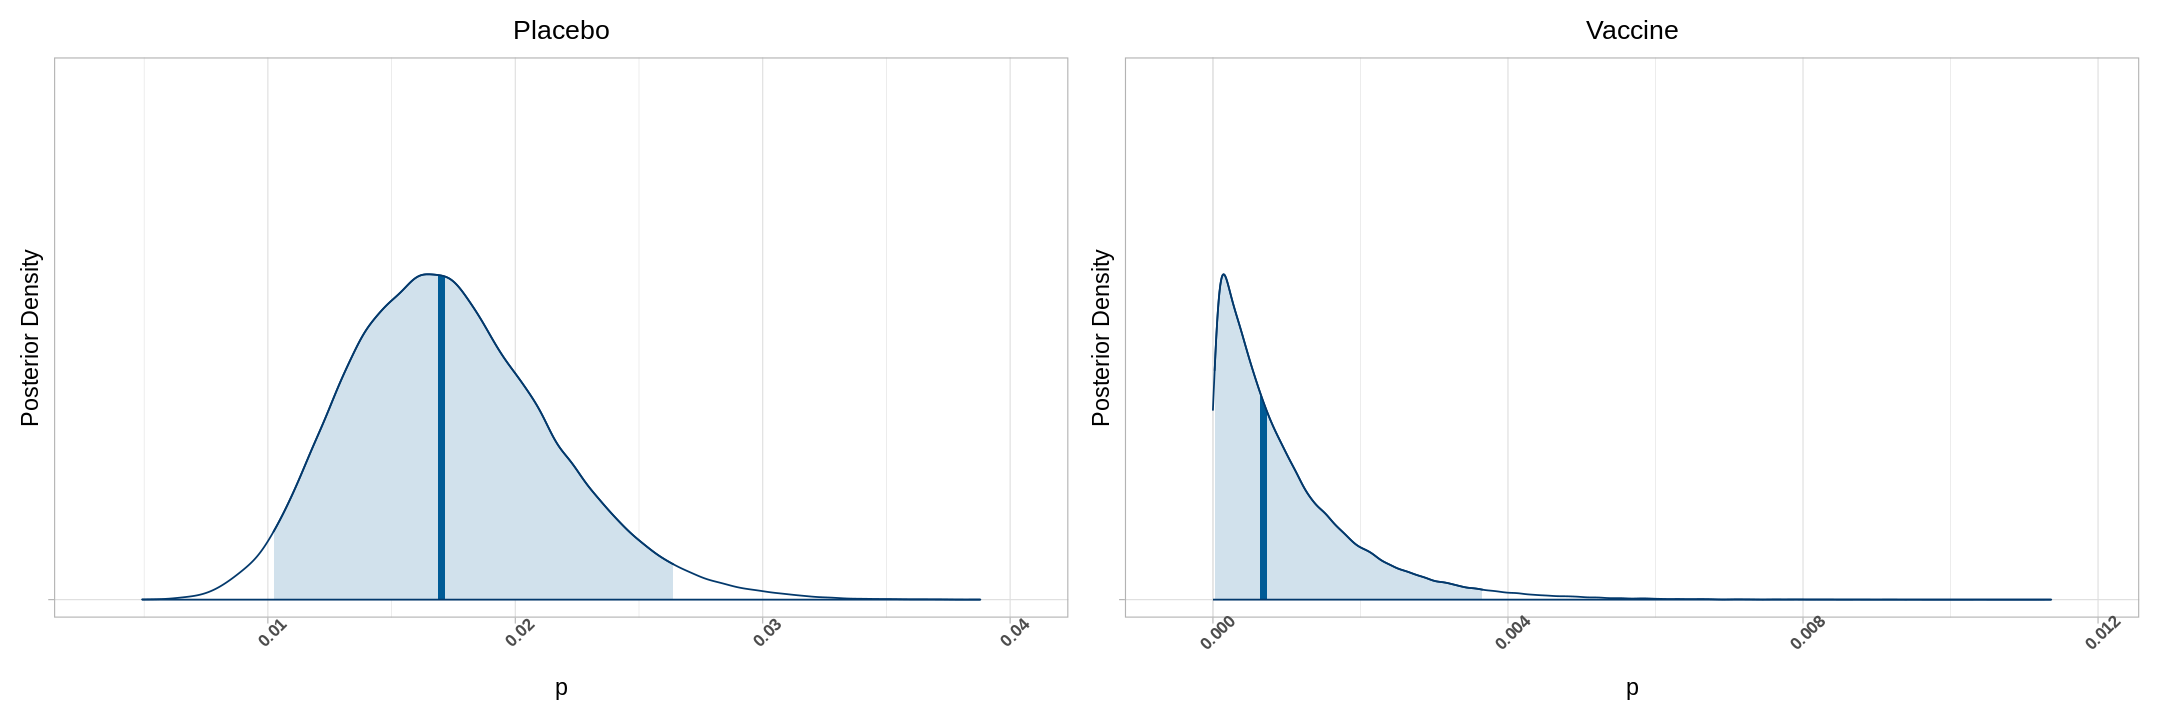

In [63]:
pfizer_res <- tidy_draws(codaSamples_Comirnaty) %>%
  select('theta[1]':'theta[2]') %>%
  rename(Placebo = 'theta[1]', Vaccine = 'theta[2]')

plot_placebo <- plot_mcmc_area(
  data = pfizer_res,
  parameter = "Placebo",
  title = "Placebo"
)

plot_vaccine <- plot_mcmc_area(
  data = pfizer_res,
  parameter = "Vaccine",
  title = "Vaccine"
)
combined_plot <- (plot_placebo | plot_vaccine)
print(combined_plot)

In [64]:
plotPosterior <- function(efficiency_data, lower_efficiency, upper_efficiency, mean_efficiency, median_efficiency,y) {
  efficiency_data <- efficiency_data[efficiency_data$efficiency >= y & efficiency_data$efficiency <= 100, ]
  p <- ggplot(efficiency_data, aes(x = efficiency, y = density)) +
    geom_area(fill = "lightskyblue3", alpha = 0.5) +
    geom_line(color = "lightskyblue3", size = 1) +
    geom_vline(xintercept = lower_efficiency, color = "steelblue", linetype = "dashed", size = 1) +
    geom_vline(xintercept = upper_efficiency, color = "steelblue", linetype = "dashed", size = 1) +
    geom_vline(xintercept = mean_efficiency, color = "steelblue", linetype = "solid", size = 2) +
    geom_vline(xintercept = median_efficiency, color = "steelblue", linetype = "solid", size = 2) +
    labs(
      x = "Efficiency (%)",
      y = "Density",
      title = "Vaccine Efficiency Distribution",
      subtitle = paste0("95% Interval: [", round(lower_efficiency, 3), ", ", round(upper_efficiency, 3), "]\nMean: ", round(mean_efficiency, 3))
    ) +
    annotate("text", x = mean_efficiency, y = max(efficiency_data$density) * 0.9, label = paste("Mean:", round(mean_efficiency, 2)), color = "black", vjust = -1, size = 5) +
    annotate("text", x = median_efficiency, y = max(efficiency_data$density) * 0.8, label = paste("Median:", round(median_efficiency, 2)), color = "black", vjust = -1, size = 5) +
    xlim(y, 100) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(size = 16, hjust = 0.5),
      plot.subtitle = element_text(size = 13, hjust = 0.5),
      axis.text.x = element_text(face = "bold", size = 10),
      axis.text.y = element_text(size = 10)
    )
  print(p)
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


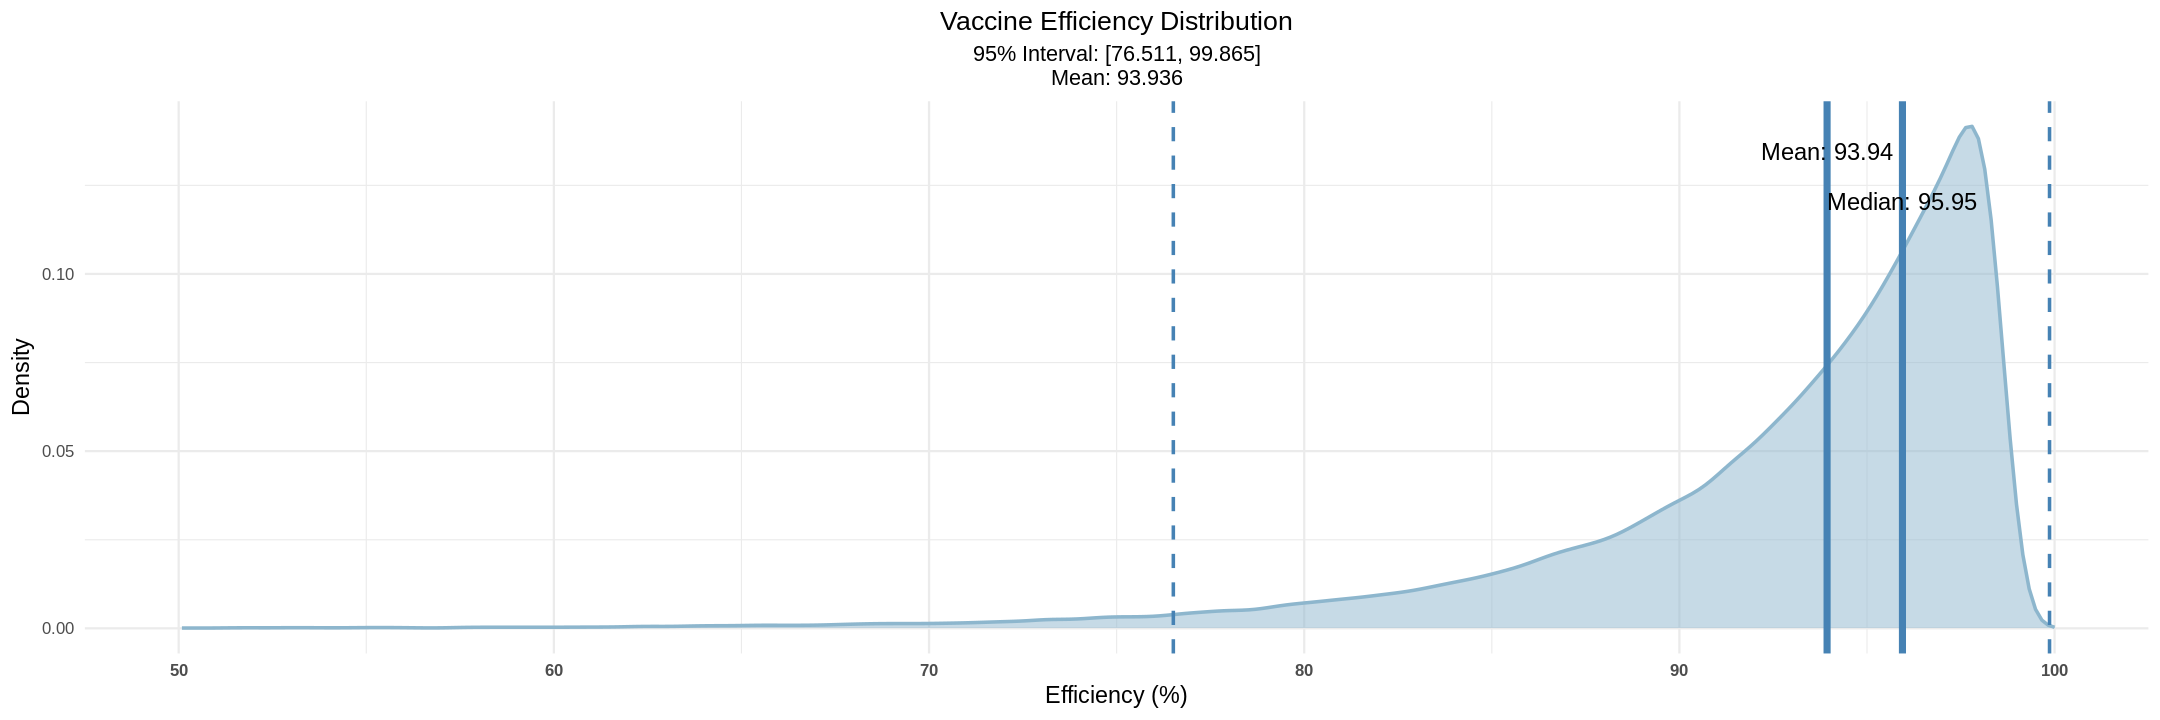

In [65]:
vaccine.efficiency_pfizer <- ((pfizer_res$Placebo - pfizer_res$Vaccine) / pfizer_res$Placebo * 100)
efficiency_pfizer <- seq(from = min(vaccine.efficiency_pfizer), to = max(vaccine.efficiency_pfizer), length.out = 512)
efficiency_pfizer_density <- density(vaccine.efficiency_pfizer)$y
efficiency_pfizer.data <- data.frame(efficiency = efficiency_pfizer, density = efficiency_pfizer_density)

mean.efficiency <- mean(vaccine.efficiency_pfizer)
median.efficiency <- quantile(vaccine.efficiency_pfizer, 0.5)
lower.efficiency <- quantile(vaccine.efficiency_pfizer, 0.025)
upper.efficiency <- quantile(vaccine.efficiency_pfizer, 0.975)


plotPosterior(efficiency_pfizer.data, lower.efficiency, upper.efficiency, mean.efficiency, median.efficiency, 50)


###Ronapreve

In [66]:
# Ronapreve data
tot_Ronapreve_vaccyoung <- 1022
tot_Ronapreve_placyoung <- 934

patient <- c(rep("vaccine", tot_Ronapreve_vaccyoung),
             rep("placebo", tot_Ronapreve_placyoung))

positive_Ronapreve_vaccyoung <- 19
positive_Ronapreve_placyoung <- 44

tested <- c(rep("pos", positive_Ronapreve_vaccyoung),
            rep("neg", tot_Ronapreve_vaccyoung - positive_Ronapreve_vaccyoung),
            rep("pos", positive_Ronapreve_placyoung),
            rep("neg", tot_Ronapreve_placyoung - positive_Ronapreve_placyoung))

Ronapreve_vaccyoung.tb <- tibble(tested = tested, patient = patient)

table(Ronapreve_vaccyoung.tb[[2]], Ronapreve_vaccyoung.tb[[1]])

# Data for JAGS
datalist_Ronapreve <- list(
  tested = ifelse(Ronapreve_vaccyoung.tb$tested == "neg", 0, 1),
  patient = as.integer(factor(Ronapreve_vaccyoung.tb$patient)),
  Ntot = length(Ronapreve_vaccyoung.tb$tested),
  Nclass = length(unique(Ronapreve_vaccyoung.tb$patient))
)

# Run the JAGS model
jagsModelRonapreve_vaccyoung <- jags.model(file = "/content/jags_model_beta _uniform.txt",
                                           data = datalist_Ronapreve,
                                           n.chain = 4, n.adapt = 500, quiet = TRUE)
# Update the model
update(jagsModelRonapreve_vaccyoung, n.iter = 500)

         
           neg  pos
  placebo  890   44
  vaccine 1003   19

In [67]:
codaSamples_Ronapreve<- coda.samples(jagsModelRonapreve_vaccyoung, variable.names = c("theta"),n.iter = 15000)

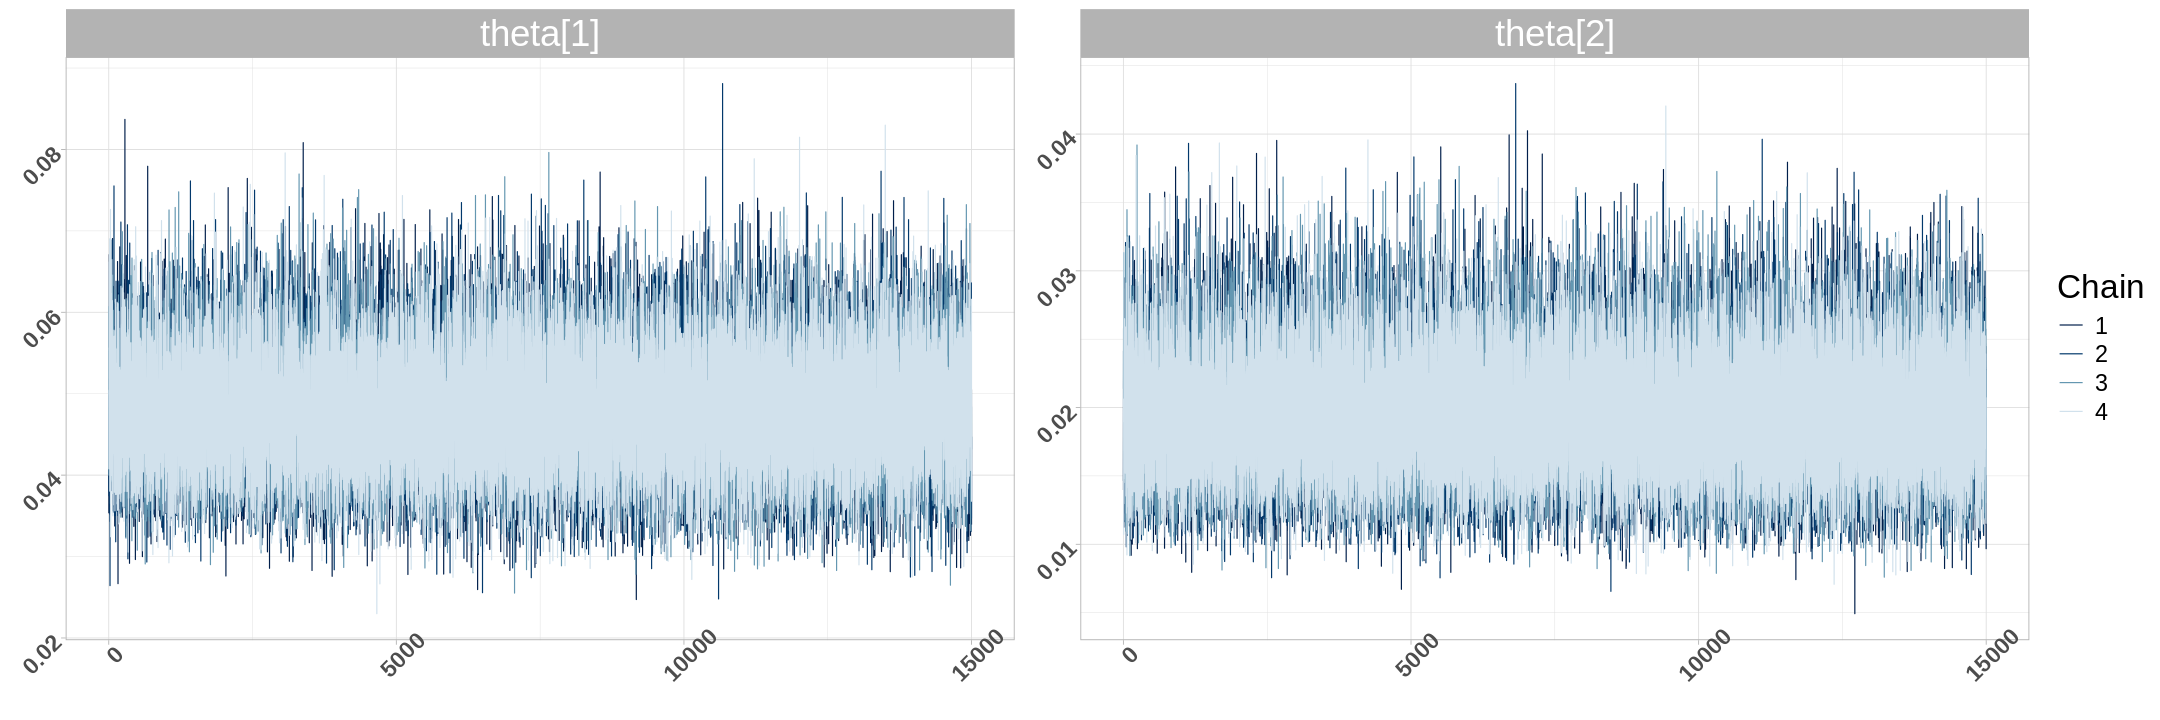

In [68]:
options(repr.plot.width = 18, repr.plot.height = 6)
p <- mcmc_trace(codaSamples_Ronapreve) +
  theme_light() +
  facet_text(size = 22) +
  theme(
    axis.text.x = element_text(face = "bold", size = 14, angle = 45),
    axis.text.y = element_text(face = "bold", size = 14, angle = 45),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 14)
  )
print(p)

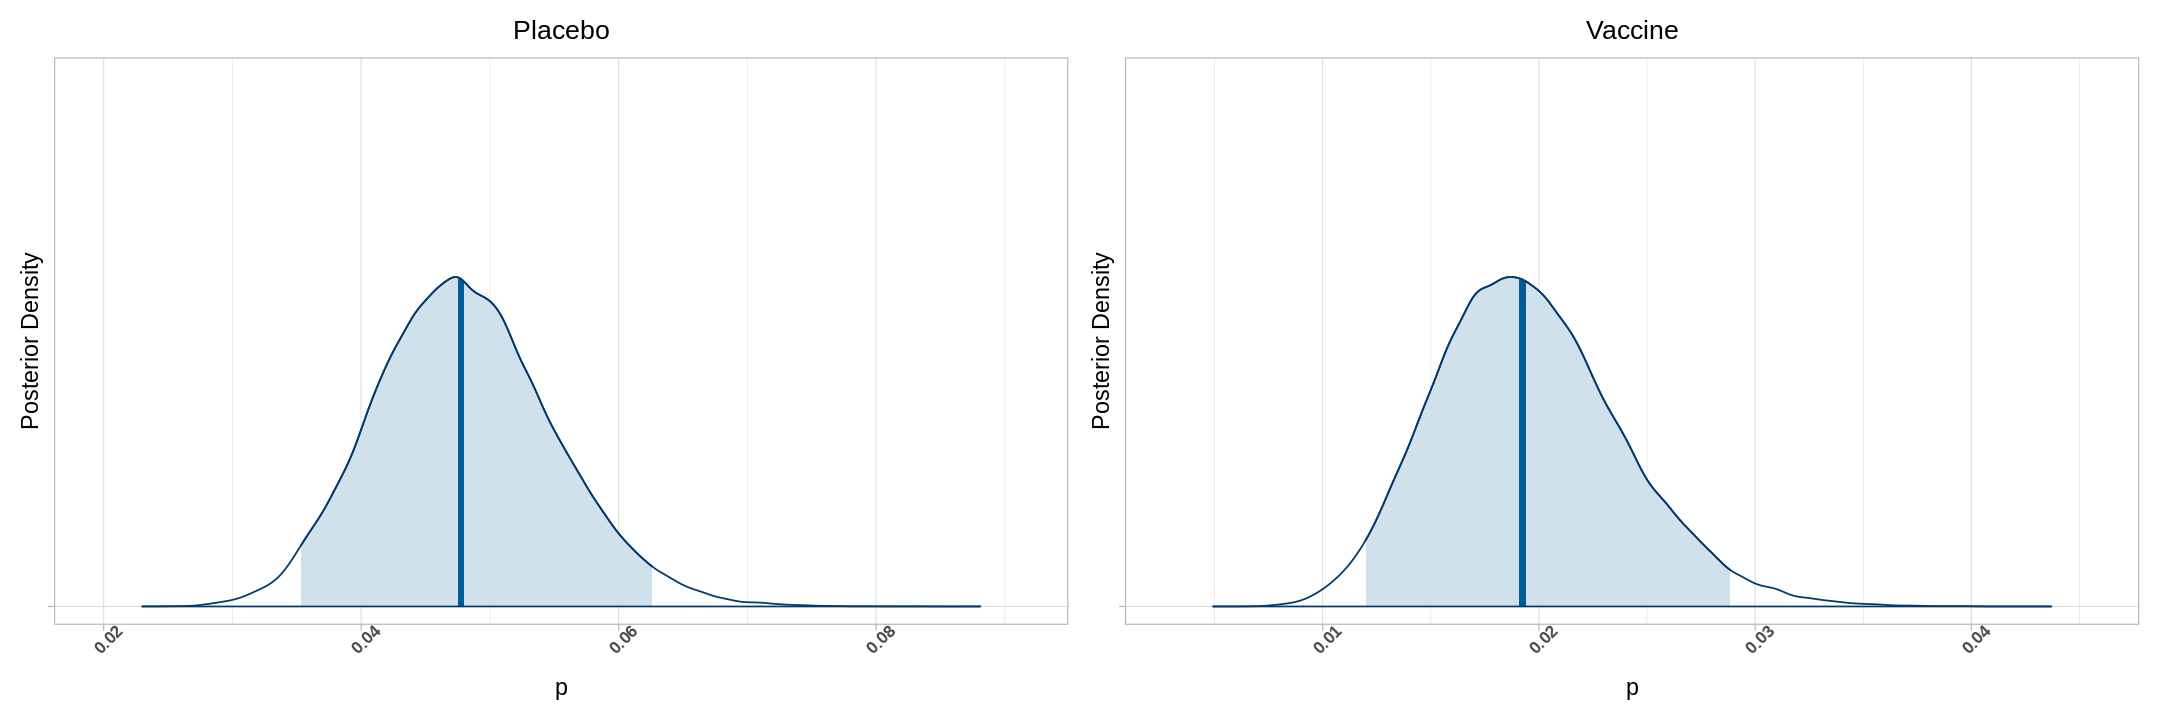

In [69]:
Ronapreve_res <- tidy_draws(codaSamples_Ronapreve) %>%
  select('theta[1]':'theta[2]') %>%
  rename(Placebo = 'theta[1]', Vaccine = 'theta[2]')

plot_placebo <- plot_mcmc_area(
  data = Ronapreve_res,
  parameter = "Placebo",
  title = "Placebo"
)

plot_vaccine <- plot_mcmc_area(
  data = Ronapreve_res,
  parameter = "Vaccine",
  title = "Vaccine"
)
combined_plot <- (plot_placebo | plot_vaccine)
print(combined_plot)

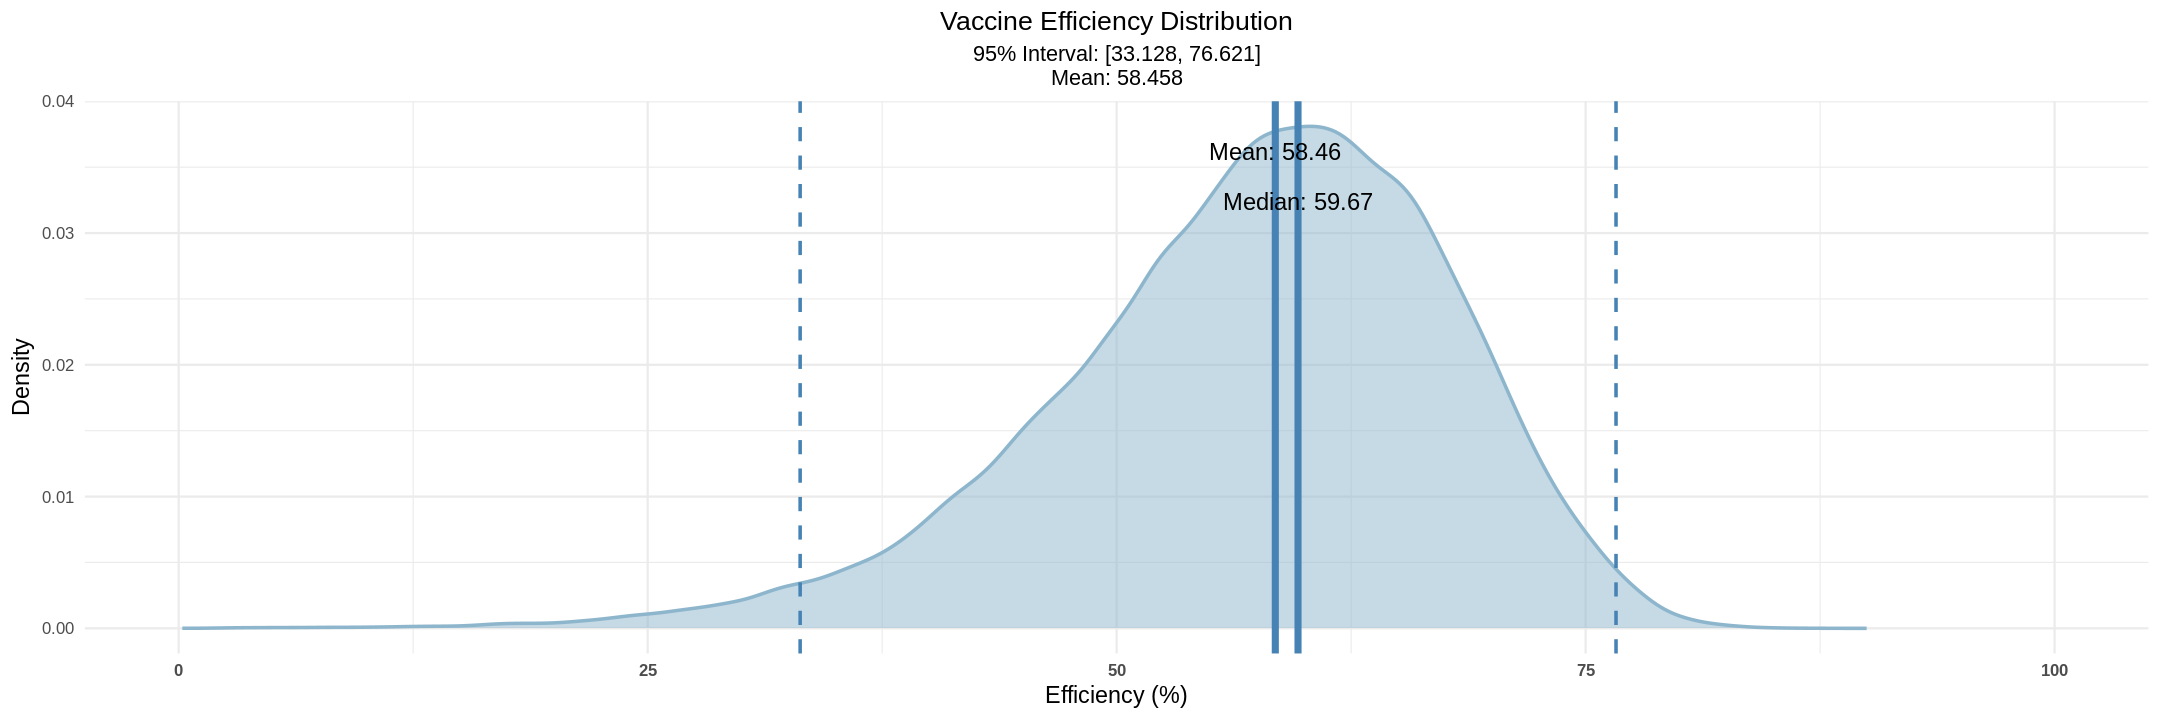

In [70]:
vaccine.efficiency_Ronapreve <- ((Ronapreve_res$Placebo - Ronapreve_res$Vaccine) / Ronapreve_res$Placebo * 100)
efficiency_Ronapreve <- seq(from = min(vaccine.efficiency_Ronapreve), to = max(vaccine.efficiency_Ronapreve), length.out = 512)
efficiency_Ronapreve_density <- density(vaccine.efficiency_Ronapreve)$y

efficiency_Ronapreve.data <- data.frame(efficiency = efficiency_Ronapreve, density = efficiency_Ronapreve_density)

mean.efficiency_Ronapreve <- mean(vaccine.efficiency_Ronapreve)
median.efficiency_Ronapreve <- quantile(vaccine.efficiency_Ronapreve, 0.5)
lower.efficiency_Ronapreve <- quantile(vaccine.efficiency_Ronapreve, 0.025)
upper.efficiency_Ronapreve <- quantile(vaccine.efficiency_Ronapreve, 0.975)


plotPosterior(efficiency_Ronapreve.data, lower.efficiency_Ronapreve, upper.efficiency_Ronapreve, mean.efficiency_Ronapreve, median.efficiency_Ronapreve, 0)

###Nuvaxovid

In [71]:
# Nuvaxovid
tot_Nuvaxovid_vaccyoung <- 1205
tot_Nuvaxovid_placyoung <- 594

patient <- c(rep("vaccine", tot_Nuvaxovid_vaccyoung),
             rep("placebo", tot_Nuvaxovid_placyoung))

positive_Nuvaxovid_vaccyoung <- 6
positive_Nuvaxovid_placyoung <- 14
tested <- c(rep("pos", positive_Nuvaxovid_vaccyoung),
            rep("neg", tot_Nuvaxovid_vaccyoung - positive_Nuvaxovid_vaccyoung),
            rep("pos", positive_Nuvaxovid_placyoung),
            rep("neg", tot_Nuvaxovid_placyoung - positive_Nuvaxovid_placyoung))


Nuvaxovid_vaccyoung.tb <- tibble(tested = tested, patient = patient)
table(Nuvaxovid_vaccyoung.tb[[2]], Nuvaxovid_vaccyoung.tb[[1]])
datalist_Nuvaxovid <- list(
  tested = ifelse(Nuvaxovid_vaccyoung.tb$tested == "neg", 0, 1),
  patient = as.integer(factor(Nuvaxovid_vaccyoung.tb$patient)),
  Ntot = length(Nuvaxovid_vaccyoung.tb$tested),
  Nclass = length(unique(Nuvaxovid_vaccyoung.tb$patient))
)

# Run the JAGS model
jagsModelNuvaxovid_vaccyoung <- jags.model(file = "/content/jags_model_beta _uniform.txt",
                                           data = datalist_Nuvaxovid,
                                           n.chain = 4, n.adapt = 500, quiet = TRUE)
# Update the model
update(jagsModelNuvaxovid_vaccyoung, n.iter = 500)

         
           neg  pos
  placebo  580   14
  vaccine 1199    6

In [72]:
codaSamples_Nuvaxovid <- coda.samples(jagsModelNuvaxovid_vaccyoung, variable.names = c("theta"),n.iter = 15000)

In [73]:
summary(codaSamples_Nuvaxovid)


Iterations = 501:15500
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 15000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean       SD  Naive SE Time-series SE
theta[1] 0.02518 0.006407 2.616e-05      2.587e-05
theta[2] 0.00580 0.002189 8.935e-06      8.792e-06

2. Quantiles for each variable:

             2.5%      25%      50%     75%   97.5%
theta[1] 0.014206 0.020574 0.024673 0.02924 0.03905
theta[2] 0.002327 0.004216 0.005527 0.00710 0.01078


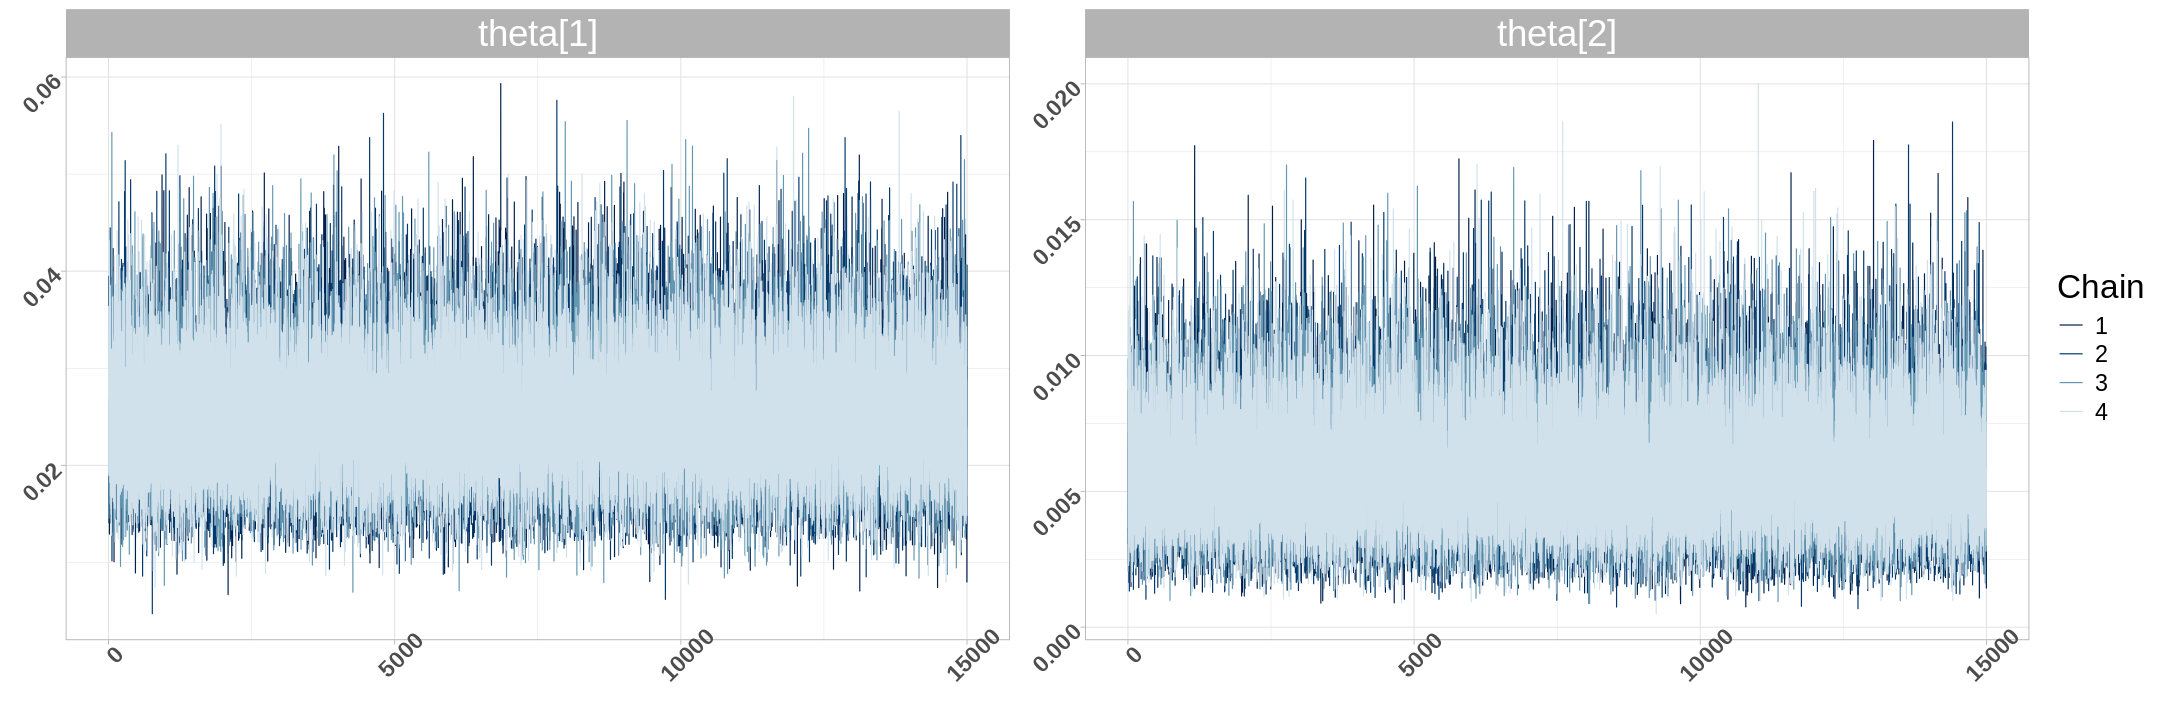

In [74]:
options(repr.plot.width = 18, repr.plot.height = 6)
p <- mcmc_trace(codaSamples_Nuvaxovid) +
  theme_light() +
  facet_text(size = 22) +
  theme(
    axis.text.x = element_text(face = "bold", size = 14, angle = 45),
    axis.text.y = element_text(face = "bold", size = 14, angle = 45),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 14)
  )
print(p)

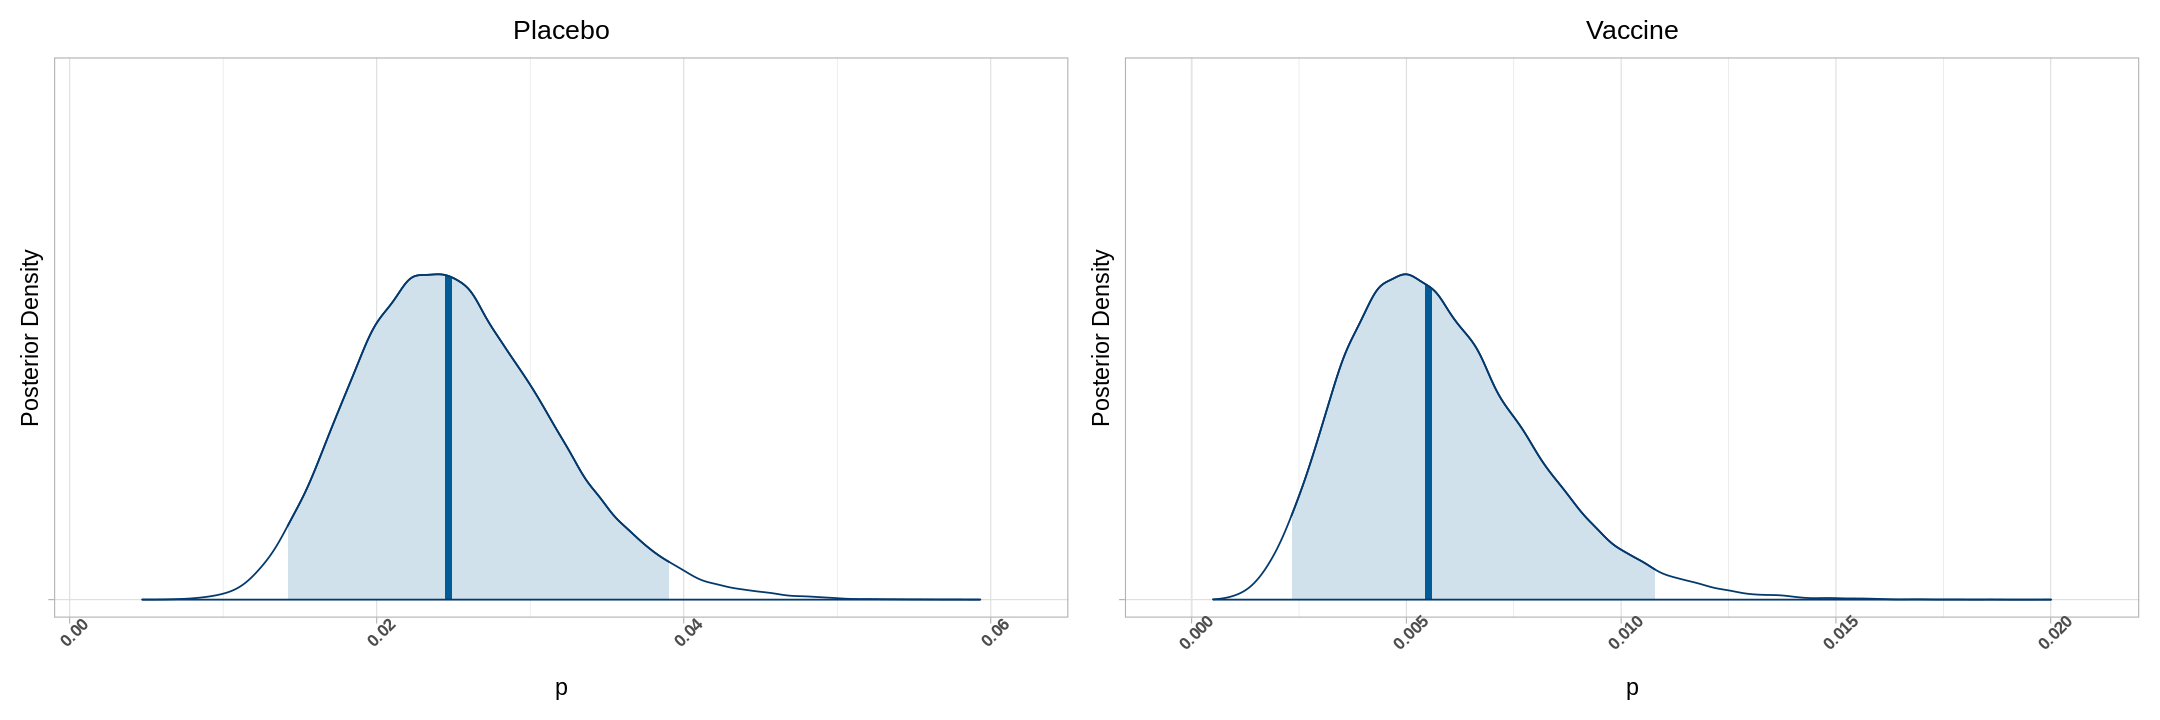

In [75]:
# Example data preparation (Replace with actual data and results)
Nuvaxovid_res <- tidy_draws(codaSamples_Nuvaxovid) %>%
  select('theta[1]':'theta[2]') %>%
  rename(Placebo = 'theta[1]', Vaccine = 'theta[2]')
plot_placebo <- plot_mcmc_area(
  data = Nuvaxovid_res,
  parameter = "Placebo",
  title = "Placebo"
)

plot_vaccine <- plot_mcmc_area(
  data = Nuvaxovid_res,
  parameter = "Vaccine",
  title = "Vaccine"
)
combined_plot <- (plot_placebo | plot_vaccine)
print(combined_plot)

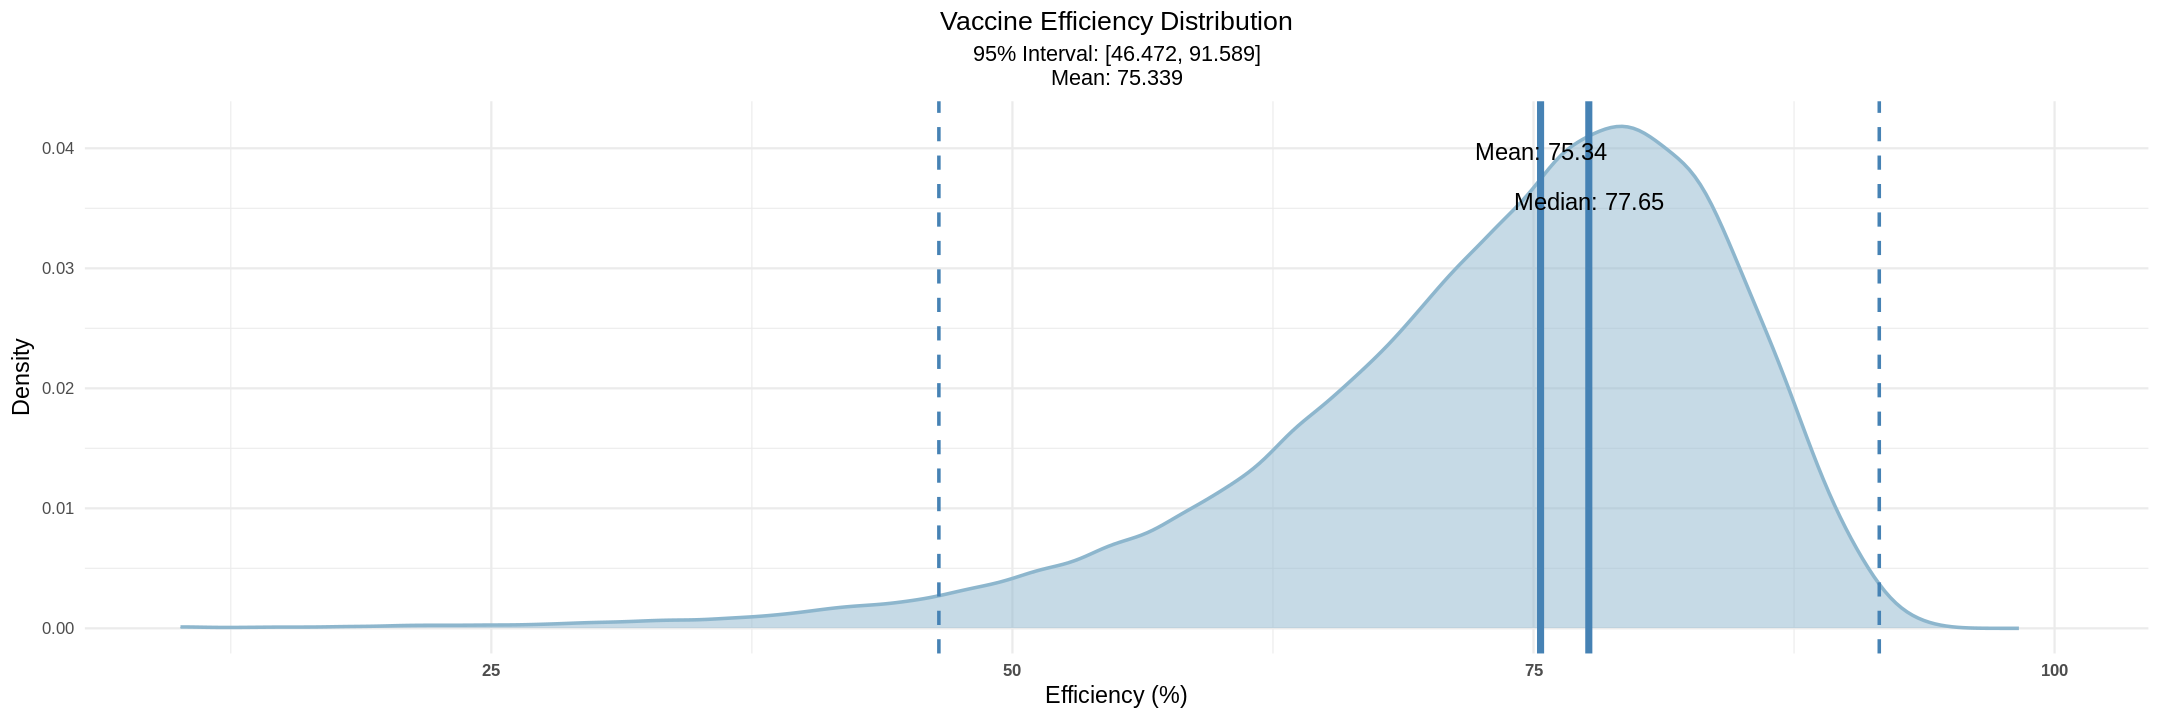

In [76]:
vaccine.efficiency_Nuvaxovid <- ((Nuvaxovid_res$Placebo - Nuvaxovid_res$Vaccine) / Nuvaxovid_res$Placebo * 100)
efficiency_Nuvaxovid <- seq(from = min(vaccine.efficiency_Nuvaxovid), to = max(vaccine.efficiency_Nuvaxovid), length.out = 512)
efficiency_Nuvaxovid_density <- density(vaccine.efficiency_Nuvaxovid)$y

efficiency_Nuvaxovid.data <- data.frame(efficiency = efficiency_Nuvaxovid, density = efficiency_Nuvaxovid_density)

mean.efficiency_Nuvaxovid <- mean(vaccine.efficiency_Nuvaxovid)
median.efficiency_Nuvaxovid <- quantile(vaccine.efficiency_Nuvaxovid, 0.5)
lower.efficiency_Nuvaxovid <- quantile(vaccine.efficiency_Nuvaxovid, 0.025)
upper.efficiency_Nuvaxovid <- quantile(vaccine.efficiency_Nuvaxovid, 0.975)


plotPosterior(efficiency_Nuvaxovid.data, lower.efficiency_Nuvaxovid, upper.efficiency_Nuvaxovid, mean.efficiency_Nuvaxovid, median.efficiency_Nuvaxovid, 10)

###Spikevax

In [77]:
# Spikevax
tot_Spikevax_vaccyoung <- 2163
tot_Spikevax_placyoung <- 1073


patient <- c(rep("vaccine", tot_Spikevax_vaccyoung),
             rep("placebo", tot_Spikevax_placyoung))


positive_Spikevax_vaccyoung <- 0
positive_Spikevax_placyoung <- 4


tested <- c(rep("pos", positive_Spikevax_vaccyoung),
            rep("neg", tot_Spikevax_vaccyoung - positive_Spikevax_vaccyoung),
            rep("pos", positive_Spikevax_placyoung),
            rep("neg", tot_Spikevax_placyoung - positive_Spikevax_placyoung))


Spikevax_vaccyoung.tb <- tibble(tested = tested, patient = patient)
table(Spikevax_vaccyoung.tb[[2]], Spikevax_vaccyoung.tb[[1]])



datalist_Spikevax <- list(
  tested = ifelse(Spikevax_vaccyoung.tb$tested == "neg", 0, 1),
  patient = as.integer(factor(Spikevax_vaccyoung.tb$patient)),
  Ntot = length(Spikevax_vaccyoung.tb$tested),
  Nclass = length(unique(Spikevax_vaccyoung.tb$patient))
)
# Run the JAGS model
jagsModelSpikevax_vaccyoung <- jags.model(file = "/content/jags_model_beta _uniform.txt",
                                          data = datalist_Spikevax,
                                          n.chain = 4, n.adapt = 500, quiet = TRUE)

# Update the model
update(jagsModelSpikevax_vaccyoung, n.iter = 500)

         
           neg  pos
  placebo 1069    4
  vaccine 2163    0

In [78]:
codaSamples_Spikevax <- coda.samples(jagsModelSpikevax_vaccyoung, variable.names = c("theta"),n.iter = 15000)

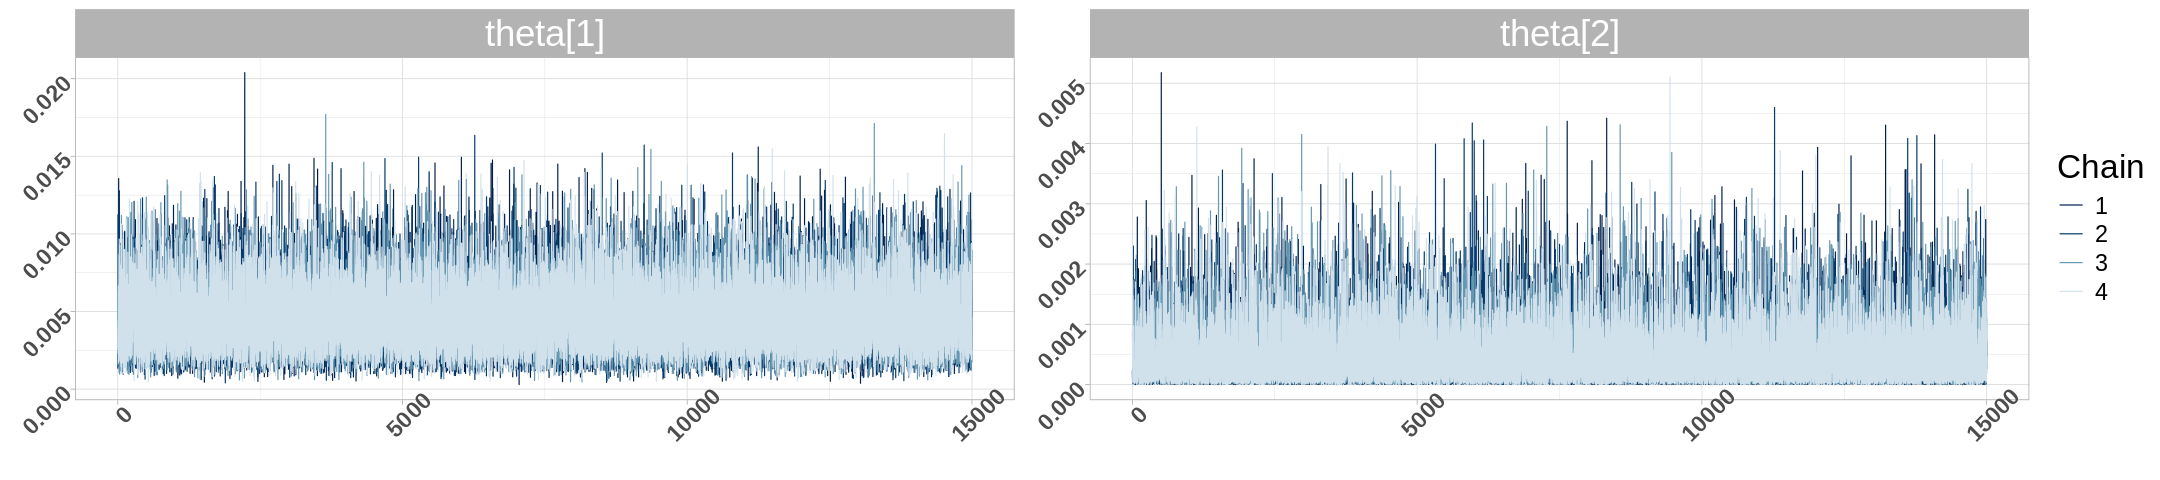

In [79]:
options(repr.plot.width = 18, repr.plot.height = 4)
p <- mcmc_trace(codaSamples_Spikevax) +
  theme_light() +
  facet_text(size = 22) +
  theme(
    axis.text.x = element_text(face = "bold", size = 14, angle = 45),
    axis.text.y = element_text(face = "bold", size = 14, angle = 45),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 14)
  )
print(p)

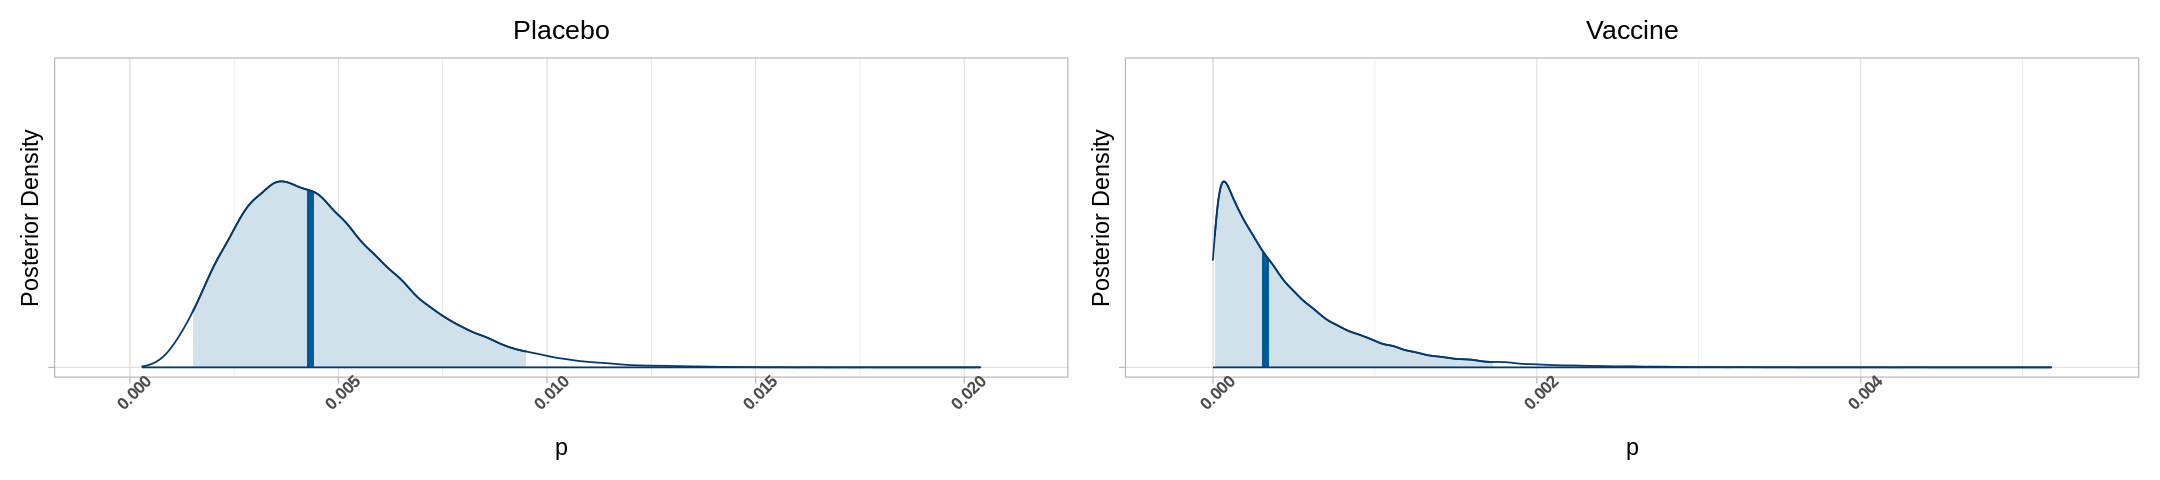

In [80]:
Spikevax_res <- tidy_draws(codaSamples_Spikevax) %>%
  select('theta[1]':'theta[2]') %>%
  rename(Placebo = 'theta[1]', Vaccine = 'theta[2]')
plot_placebo <- plot_mcmc_area(
  data = Spikevax_res,
  parameter = "Placebo",
  title = "Placebo"
)
plot_vaccine <- plot_mcmc_area(
  data = Spikevax_res,
  parameter = "Vaccine",
  title = "Vaccine"
)
combined_plot_Spikevax <- (plot_placebo | plot_vaccine)
print(combined_plot_Spikevax)

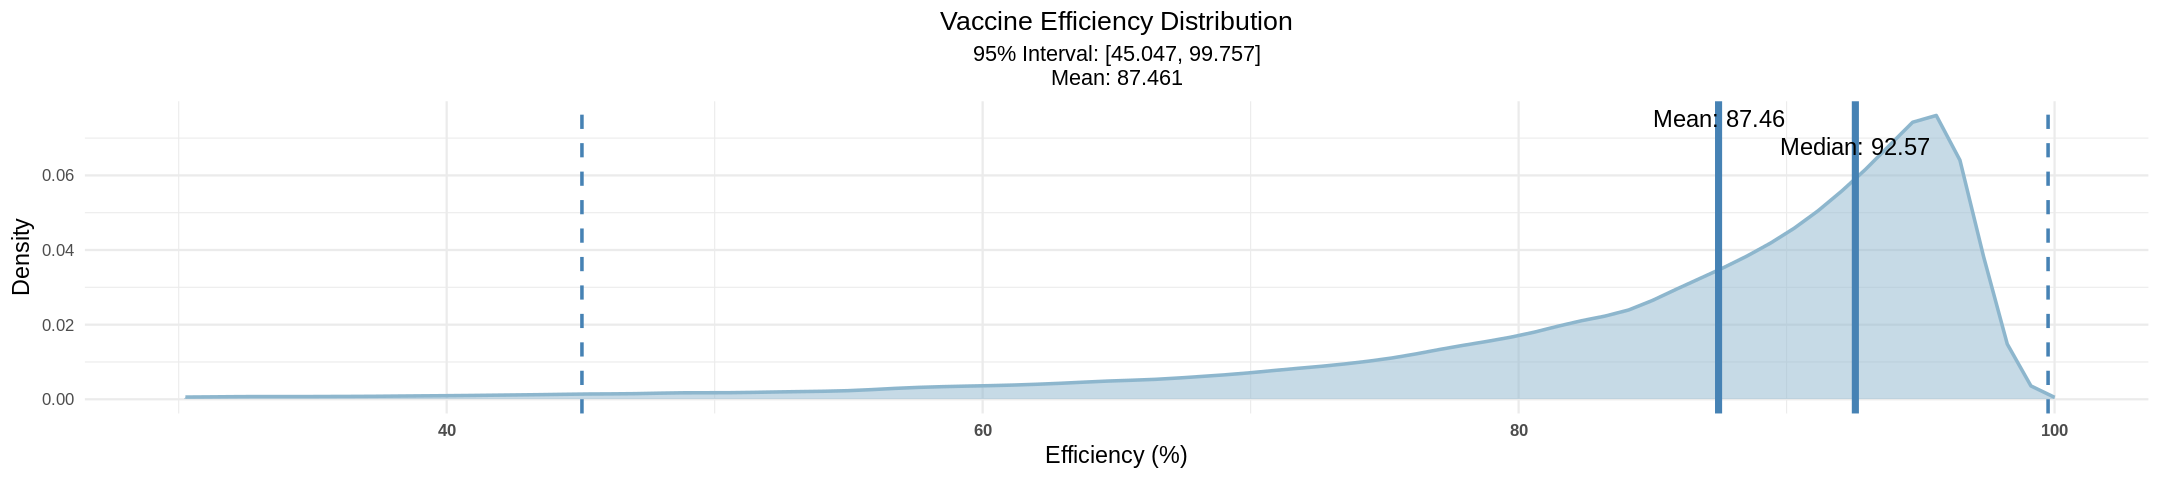

In [81]:
vaccine.efficiency_Spikevax <- ((Spikevax_res$Placebo - Spikevax_res$Vaccine) / Spikevax_res$Placebo * 100)
efficiency_Spikevax <- seq(from = min(vaccine.efficiency_Spikevax), to = max(vaccine.efficiency_Spikevax), length.out = 512)

efficiency_Spikevax_density <- density(vaccine.efficiency_Spikevax)$y
efficiency_Spikevax.data <- data.frame(efficiency = efficiency_Spikevax, density = efficiency_Spikevax_density)


mean.efficiency_Spikevax <- mean(vaccine.efficiency_Spikevax)
median.efficiency_Spikevax <- quantile(vaccine.efficiency_Spikevax, 0.5)
lower.efficiency_Spikevax <- quantile(vaccine.efficiency_Spikevax, 0.025)
upper.efficiency_Spikevax <- quantile(vaccine.efficiency_Spikevax, 0.975)


plotPosterior(efficiency_Spikevax.data, lower.efficiency_Spikevax, upper.efficiency_Spikevax, mean.efficiency_Spikevax, median.efficiency_Spikevax, 30)

###Comprison between the vaccine effectiveness of young people

In [82]:
pfizer.efficiency <- ((pfizer_res$Placebo - pfizer_res$Vaccine) / pfizer_res$Placebo * 100)
pfizer.data <- data.frame(
  efficiency = seq(from = min(pfizer.efficiency), to = max(pfizer.efficiency), length.out = 512),
  density = density(pfizer.efficiency)$y,
  vaccine = "Comirnaty"
)

ronapreve.efficiency <- ((Ronapreve_res$Placebo - Ronapreve_res$Vaccine) / Ronapreve_res$Placebo * 100)
ronapreve.data <- data.frame(
  efficiency = seq(from = min(ronapreve.efficiency), to = max(ronapreve.efficiency), length.out = 512),
  density = density(ronapreve.efficiency)$y,
  vaccine = "Ronapreve"
)

nuvaxovid.efficiency <- ((Nuvaxovid_res$Placebo - Nuvaxovid_res$Vaccine) / Nuvaxovid_res$Placebo * 100)
nuvaxovid.data <- data.frame(
  efficiency = seq(from = min(nuvaxovid.efficiency), to = max(nuvaxovid.efficiency), length.out = 512),
  density = density(nuvaxovid.efficiency)$y,
  vaccine = "Nuvaxovid"
)

spikevax.efficiency <- ((Spikevax_res$Placebo - Spikevax_res$Vaccine) / Spikevax_res$Placebo * 100)
spikevax.data <- data.frame(
  efficiency = seq(from = min(spikevax.efficiency), to = max(spikevax.efficiency), length.out = 512),
  density = density(spikevax.efficiency)$y,
  vaccine = "Spikevax"
)

combined_data1 <- rbind(pfizer.data, ronapreve.data, nuvaxovid.data, spikevax.data)
summary_stats1 <- data.frame(
  vaccine = c("Comirnaty", "Ronapreve", "Nuvaxovid", "Spikevax"),
  mean = c(mean(pfizer.efficiency), mean(ronapreve.efficiency), mean(nuvaxovid.efficiency), mean(spikevax.efficiency)),
  median = c(quantile(pfizer.efficiency, 0.5), quantile(ronapreve.efficiency, 0.5), quantile(nuvaxovid.efficiency, 0.5), quantile(spikevax.efficiency, 0.5)),
  lower_95CI = c(quantile(pfizer.efficiency, 0.025), quantile(ronapreve.efficiency, 0.025), quantile(nuvaxovid.efficiency, 0.025), quantile(spikevax.efficiency, 0.025)),
  upper_95CI = c(quantile(pfizer.efficiency, 0.975), quantile(ronapreve.efficiency, 0.975), quantile(nuvaxovid.efficiency, 0.975), quantile(spikevax.efficiency, 0.975))
)

Warning message:
“Removed 1015 rows containing missing values or values outside the scale range
(`geom_line()`).”


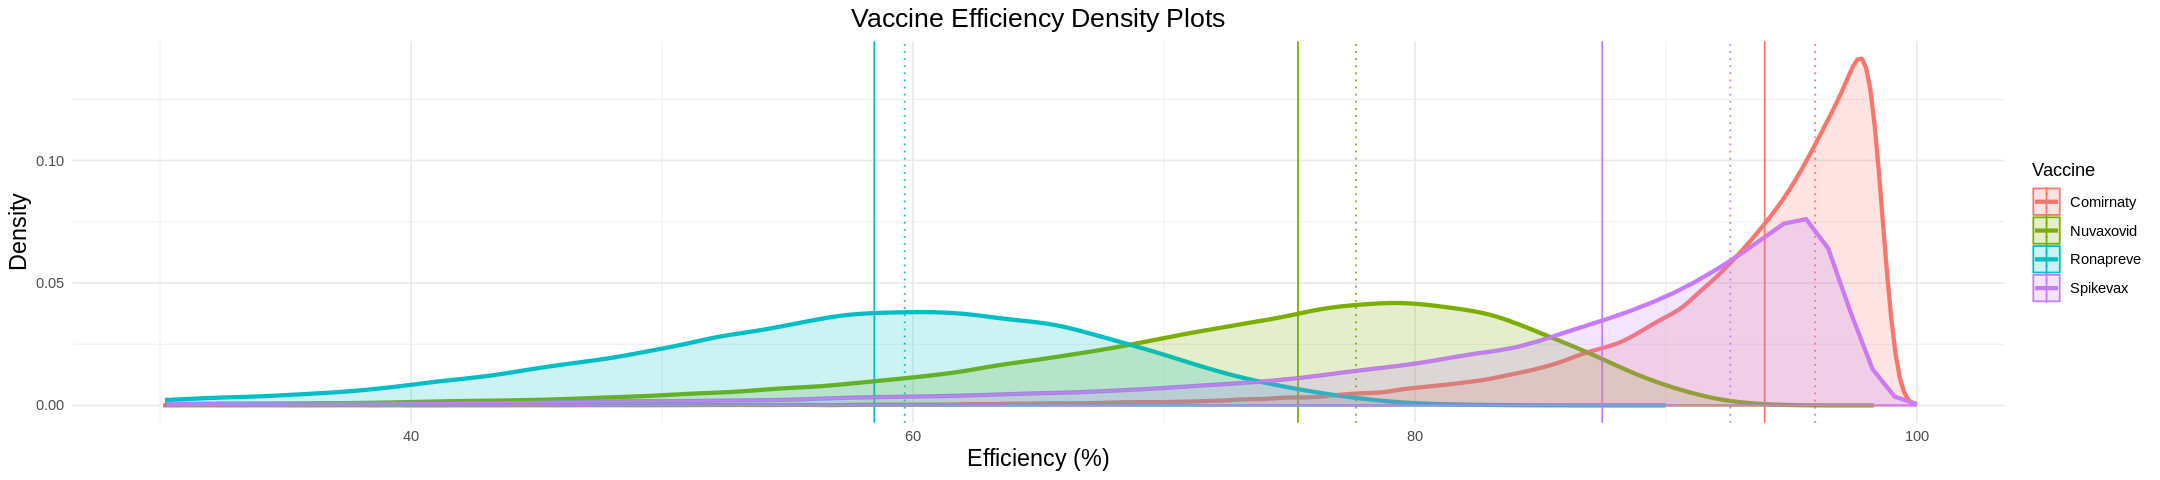

In [85]:
ggplot(combined_data1, aes(x = efficiency, y = density, color = vaccine)) +
  geom_line(size = 1.2) +
  geom_vline(data = summary_stats1, aes(xintercept = mean, color = vaccine), linetype = "solid") +
  geom_vline(data = summary_stats1, aes(xintercept = median, color = vaccine), linetype = "dotted") +
  geom_ribbon(data = combined_data1, aes(ymin = 0, ymax = density, fill = vaccine), alpha = 0.2) +
  theme_minimal() +
  xlim(30, 100)+
  labs(
    title = "Vaccine Efficiency Density Plots",
    x = "Efficiency (%)",
    y = "Density",
    color = "Vaccine",
    fill = "Vaccine"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14)
  )

##Efficacy comparison for different age groups for Comirnaty

###Efficacy of Comirnaty under 65

In [86]:
tot_Comirnaty_vaccl65    <- 10653

tot_Comirnaty_placl65    <- 10738


patient <- c(rep("vaccine",tot_Comirnaty_vaccl65),
             rep("placebo",tot_Comirnaty_placl65))
positive_Comirnaty_vaccl65  <- 7
positive_Comirnaty_placl65 <- 64
tested <- c(rep("pos",positive_Comirnaty_vaccl65),
          rep("neg",tot_Comirnaty_vaccl65-positive_Comirnaty_vaccl65),
          rep("pos",positive_Comirnaty_placl65),
          rep("neg",tot_Comirnaty_placl65-positive_Comirnaty_placl65))

Comirnaty_vaccl65.tb <- tibble (tested=tested , patient=patient)
table(Comirnaty_vaccl65.tb[[2]],Comirnaty_vaccl65.tb[[1]])

datalist_Comirnaty_vaccl65 <- list(
  tested = ifelse(Comirnaty_vaccl65.tb $tested == "neg", 0, 1),
  patient = as.integer(factor(Comirnaty_vaccl65.tb $patient)),
  Ntot = length(Comirnaty_vaccl65.tb$tested),
  Nclass = length(unique(Comirnaty_vaccl65.tb$patient))
)
jagsModelComirnaty_vaccl65 <- jags.model(file = "/content/jags_model_beta _uniform.txt",data=datalist_Comirnaty_vaccl65,n.chain=4,n.adapt=500,quiet = TRUE)
update(jagsModelComirnaty_vaccl65,n.iter=500)


         
            neg   pos
  placebo 10674    64
  vaccine 10646     7

In [87]:
codaSamples_Comirnaty31l65 <- coda.samples(jagsModelComirnaty_vaccl65, variable.names = c("theta"),n.iter = 15000)


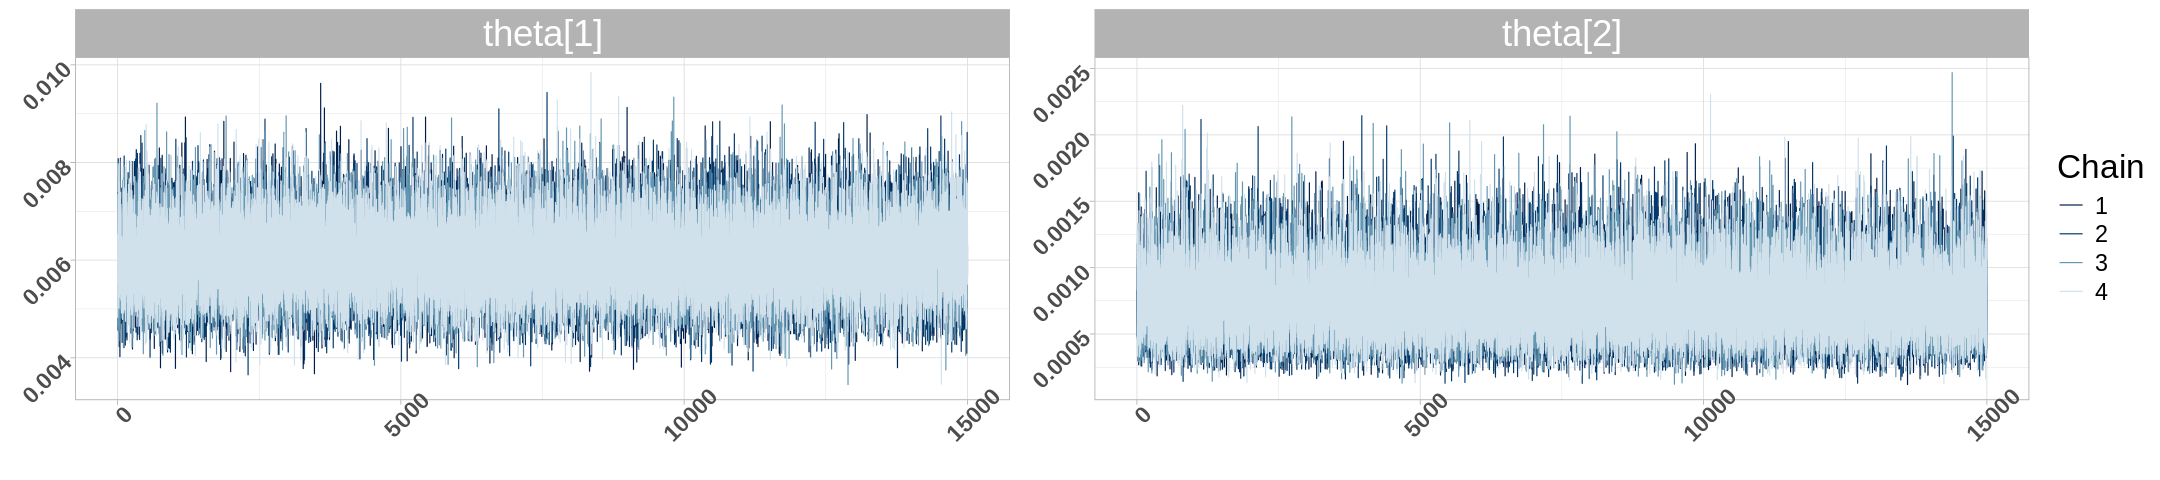

In [88]:
options(repr.plot.width = 18, repr.plot.height = 4)
p <- mcmc_trace(codaSamples_Comirnaty31l65) +
  theme_light() +
  facet_text(size = 22) +
  theme(
    axis.text.x = element_text(face = "bold", size = 14, angle = 45),
    axis.text.y = element_text(face = "bold", size = 14, angle = 45),
    legend.title = element_text(size = 20),
    legend.text = element_text(size = 14)
  )
print(p)

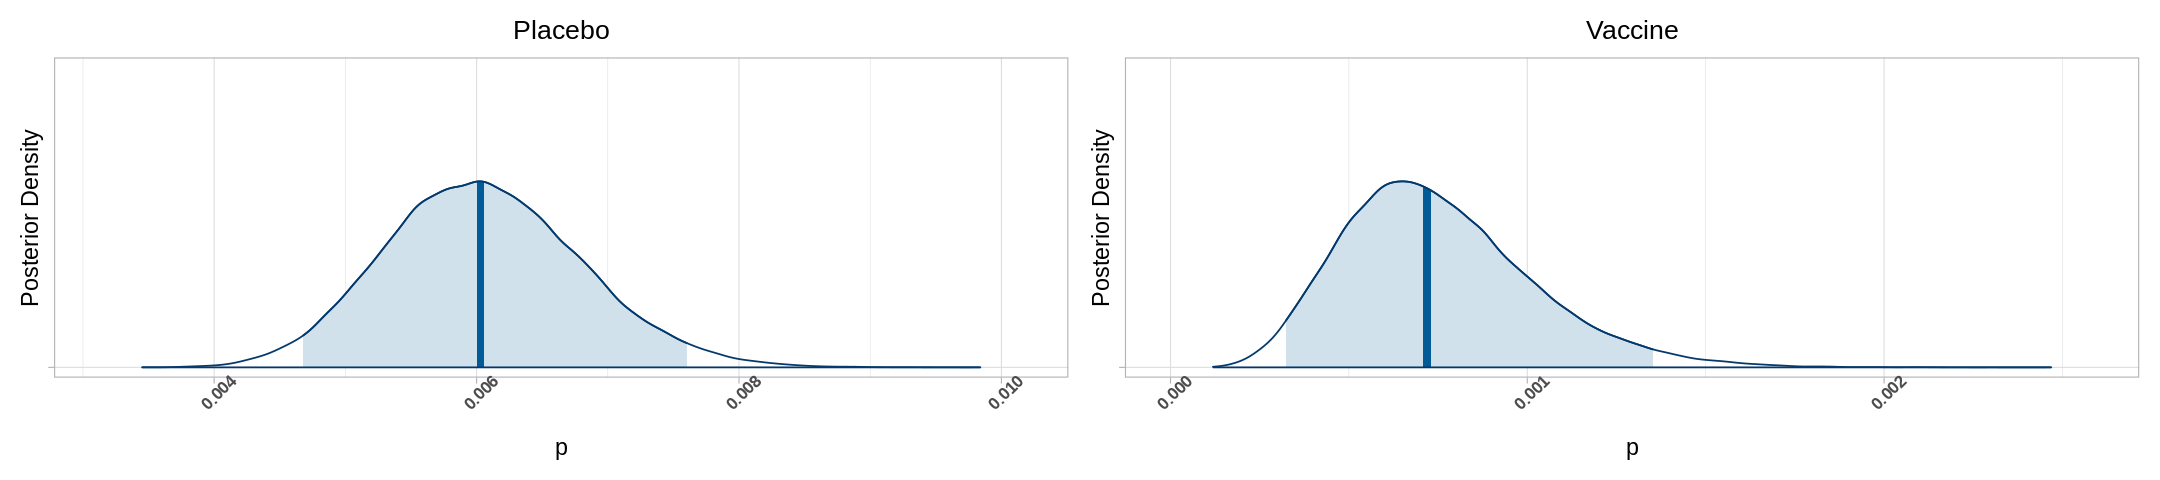

In [89]:
Comirnaty31l65_res <- tidy_draws(codaSamples_Comirnaty31l65) %>%
  select('theta[1]':'theta[2]') %>%
  rename(Placebo = 'theta[1]', Vaccine = 'theta[2]')
plot_placebo <- plot_mcmc_area(
  data = Comirnaty31l65_res,
  parameter = "Placebo",
  title = "Placebo"
)
plot_vaccine <- plot_mcmc_area(
  data = Comirnaty31l65_res,
  parameter = "Vaccine",
  title = "Vaccine"
)
combined_plot_Comirnaty31l65 <- (plot_placebo | plot_vaccine)
print(combined_plot_Comirnaty31l65)

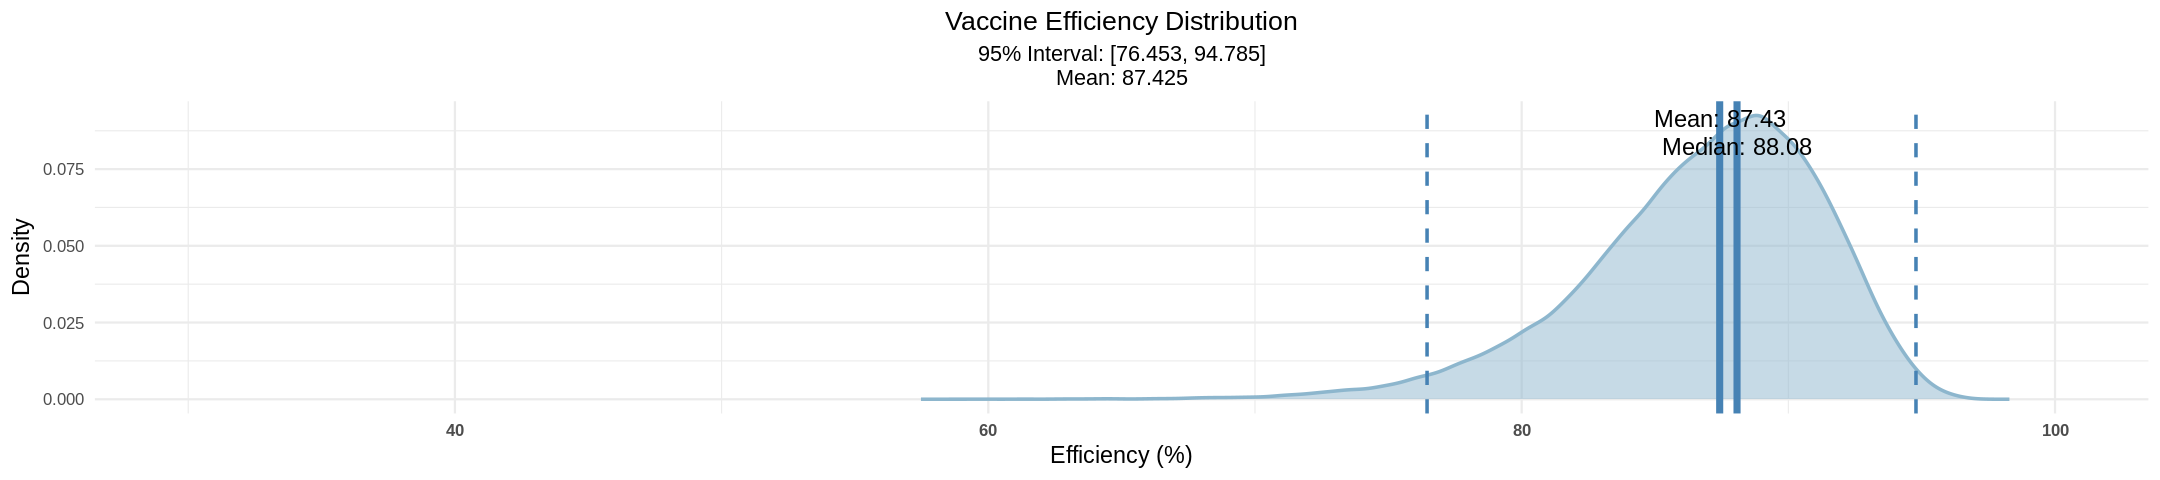

In [90]:
vaccine.efficiency_Comirnaty31l65 <- ((Comirnaty31l65_res$Placebo - Comirnaty31l65_res$Vaccine) / Comirnaty31l65_res$Placebo * 100)
efficiency_Comirnaty31l65 <- seq(from = min(vaccine.efficiency_Comirnaty31l65), to = max(vaccine.efficiency_Comirnaty31l65), length.out = 512)

efficiency_Comirnaty31l65_density <- density(vaccine.efficiency_Comirnaty31l65)$y
efficiency_Comirnaty31l65.data <- data.frame(efficiency = efficiency_Comirnaty31l65, density = efficiency_Comirnaty31l65_density)

mean.efficiency_Comirnaty31l65 <- mean(vaccine.efficiency_Comirnaty31l65)
median.efficiency_Comirnaty31l65 <- quantile(vaccine.efficiency_Comirnaty31l65, 0.5)
lower.efficiency_Comirnaty31l65 <- quantile(vaccine.efficiency_Comirnaty31l65, 0.025)
upper.efficiency_Comirnaty31l65 <- quantile(vaccine.efficiency_Comirnaty31l65, 0.975)


plotPosterior(efficiency_Comirnaty31l65.data, lower.efficiency_Comirnaty31l65, upper.efficiency_Comirnaty31l65, mean.efficiency_Comirnaty31l65, median.efficiency_Comirnaty31l65, 30)

###Comparison between age groups for Comirnaty Vaccine

In [91]:
pfizer.efficiency <- ((pfizer_res$Placebo - pfizer_res$Vaccine) / pfizer_res$Placebo * 100)
pfizer.data <- data.frame(
  efficiency = seq(from = min(pfizer.efficiency), to = max(pfizer.efficiency), length.out = 512),
  density = density(pfizer.efficiency)$y,
  vaccine = "Comirnaty Under 25"
)


Comirnaty31l65.efficiency <- ((Comirnaty31l65_res$Placebo - Comirnaty31l65_res$Vaccine) / Comirnaty31l65_res$Placebo * 100)
Comirnaty31l65.data <- data.frame(
  efficiency = seq(from = min(Comirnaty31l65.efficiency), to = max(Comirnaty31l65.efficiency), length.out = 512),
  density = density(Comirnaty31l65.efficiency)$y,
  vaccine = "Comirnaty Under 65"
)

combined_data <- rbind(pfizer.data, Comirnaty31l65.data)
summary_stats <- data.frame(
  vaccine = c("Comirnaty Under 25", "Comirnaty Under 65"),
  mean = c(mean(pfizer.efficiency), mean(Comirnaty31l65.efficiency)),
  median = c(quantile(pfizer.efficiency, 0.5), quantile(Comirnaty31l65.efficiency, 0.5)),
  lower_95CI = c(quantile(pfizer.efficiency, 0.025), quantile(Comirnaty31l65.efficiency, 0.025)),
  upper_95CI = c(quantile(pfizer.efficiency, 0.975), quantile(Comirnaty31l65.efficiency, 0.975))
)

Warning message:
“Removed 98 rows containing missing values or values outside the scale range
(`geom_line()`).”


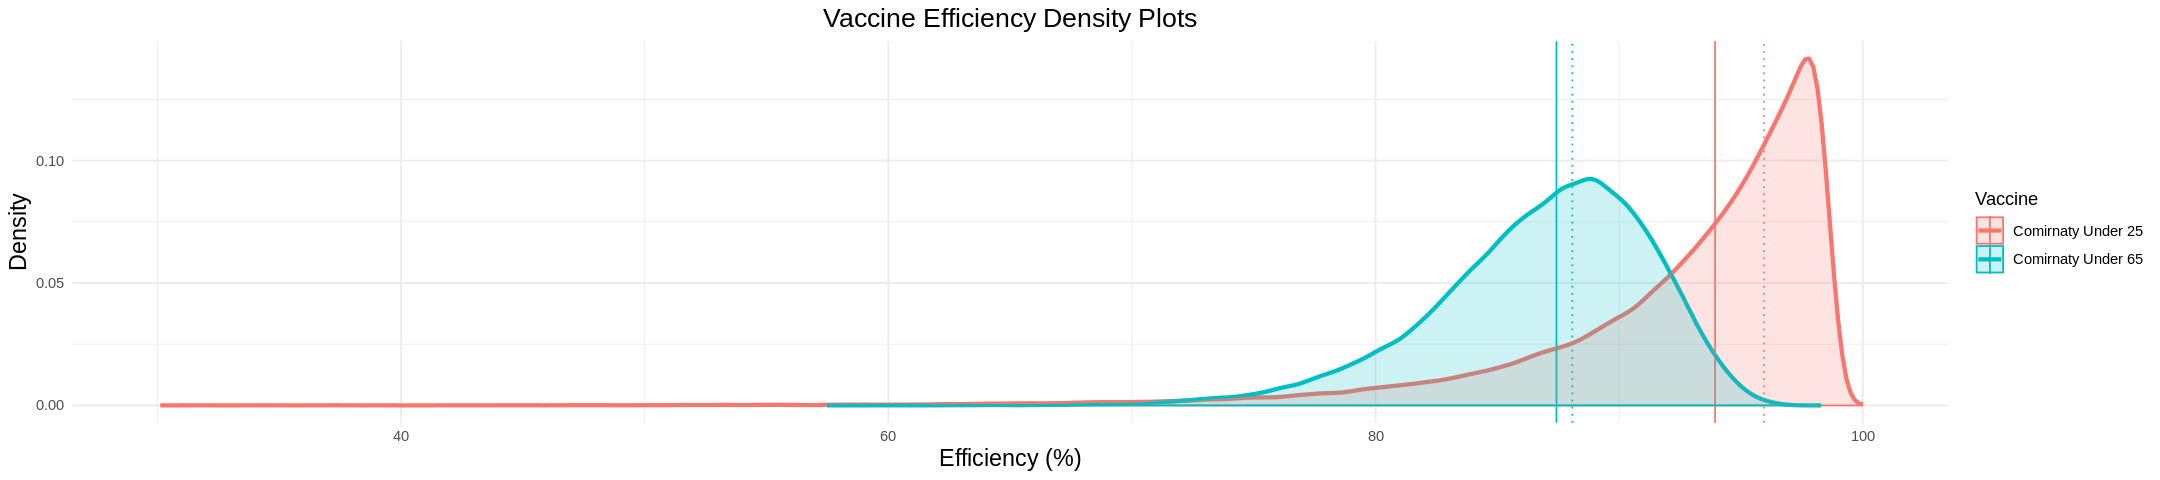

In [92]:
ggplot(combined_data, aes(x = efficiency, y = density, color = vaccine)) +
  geom_line(size = 1.2) +
  geom_vline(data = summary_stats, aes(xintercept = mean, color = vaccine), linetype = "solid") +
  geom_vline(data = summary_stats, aes(xintercept = median, color = vaccine), linetype = "dotted") +
  geom_ribbon(data = combined_data, aes(ymin = 0, ymax = density, fill = vaccine), alpha = 0.2) +
  theme_minimal() +
  xlim(30, 100) +
  labs(
    title = "Vaccine Efficiency Density Plots",
    x = "Efficiency (%)",
    y = "Density",
    color = "Vaccine",
    fill = "Vaccine"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14)
  )


# Conclusions

- We observe high efficiency for the three covid vaccines that deal with reducing symptomatic covid from healthy patients. Specially for Comirnaty and Spikevax vaccines (the 95% interval is around 89%-90% to 97%). Nuvaxovid performs worse, the median value falls outisde the 95% confidence interval of the other two, but still very effective with a confidence interval that ranges from 82% to 94%.

- For covid vaccines specialized in reducing the number of hospitalizations, both ronapreve and xevudy have a very similar efficiency with a 95% confidence interval that goes from around 47%-53% to 85-90%. The efficiency is good but worse than the previous case.

- Ronapreve works well to prevent symptomatic covid for negative tested patients (the 95% interval goes from 65% to 90%) with an infected household member but poorly in case the patient already tested positive (the 95% interval ranges from 0% to 53%).

- Based on the vaccine efficiency data for young people under 25, Comirnaty and Spikevax demonstrate the highest levels of accuracy. Comirnaty leads with the highest mean efficiency at 93.88%, supported by a 95% confidence interval of [76.411, 99.853], while Spikevax follows closely with a mean efficiency of 87.684% and a confidence interval of [46.524, 99.746].

- Nuvaxovid shows moderate effectiveness with a mean efficiency of 75.391% and a 95% confidence interval of (46.309, 91.575]. On the other hand, Ronapreve (Regeneron) has the lowest efficiency among the vaccines, with a mean of 58.

- Overall, Comirnaty and Spikevax are the most effective vaccines for young people under 25, with Nuvaxovid and Ronapreve being comparatively less effective.

- With the availabel data with Comirnaty vaccine age under 65 was studied and compared with age under 25 years data. The results were suggest that age under 65 category shows less effective than under 25 which means 25-65 age category shows less effectivenesss than under 25.